# Propensity analysis

### Imports

In [1]:
import copy
import itertools
import pickle
import random
import scipy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Note will call statsmodels for kde if installed on system, otherwise will use scipy
from collections import OrderedDict

In [2]:
sns.set()

### Functions and variable definitions

In [3]:
"""
Defines dictionary of amino acid abbreviations
"""
aa_dict = OrderedDict({'A': 'Ala',
                       'R': 'Arg',
                       'N': 'Asn',
                       'D': 'Asp',
                       'C': 'Cys',
                       'Q': 'Gln',
                       'E': 'Glu',
                       'G': 'Gly', 
                       'H': 'His',
                       'I': 'Ile',
                       'L': 'Leu',
                       'K': 'Lys',
                       'M': 'Met',
                       'F': 'Phe',
                       'P': 'Pro',
                       'S': 'Ser',
                       'T': 'Thr',
                       'W': 'Trp',
                       'Y': 'Tyr',
                       'V': 'Val'})

In [4]:
def define_dict(dict_vals):
    """
    Defines a dictionary of amino acid properties. Allows quick definition of new property dictionaries (can
    simply copy and paste the new property values from e.g. the Amino Acid Index) 
    Input: a list (dict_vals) of property values for the 20 (alphabetically ordered) amino acids
    Returns: a dictionary of these property values
    """
    aa_dict = OrderedDict({'A': dict_vals[0],
                           'R': dict_vals[1],
                           'N': dict_vals[2],
                           'D': dict_vals[3],
                           'C': dict_vals[4],
                           'Q': dict_vals[5],
                           'E': dict_vals[6],
                           'G': dict_vals[7],
                           'H': dict_vals[8],
                           'I': dict_vals[9],
                           'L': dict_vals[10],
                           'K': dict_vals[11],
                           'M': dict_vals[12],
                           'F': dict_vals[13],
                           'P': dict_vals[14],
                           'S': dict_vals[15],
                           'T': dict_vals[16],
                           'W': dict_vals[17],
                           'Y': dict_vals[18],
                           'V': dict_vals[19]})
    return aa_dict

In [5]:
def remove_nan(prop_list):
    """
    Removes all instances of '', 'NaN' and np.nan from an input list
    Input: a list (prop_list) to be filtered
    Returns: the filtered list
    """
    prop_remove_list = ['', 'NaN', 'nan', np.nan]
    for prop_remove in prop_remove_list:
        if prop_remove in prop_list:
            prop_list = [x for x in prop_list if x != prop_remove]
    return prop_list

In [6]:
def calc_distribution(df, aa_dict):
    """
    Counts the number of each amino acid in dataframe of barrel / sandwich properties
    Input: dataframe of barrel / sandwich properties and dictionary of amino acid abbreviations
    Returns: dataframe of count data
    """
    distribution_list = ['']*len(aa_dict.keys())
    fasta_list = [x for x in df['fasta_seq'].tolist() if x in list(aa_dict.keys())]
    for index, aa in enumerate(list(aa_dict.keys())):
        count = fasta_list.count(aa)
        distribution_list[index] = count / len(fasta_list)

    df_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_dict['Normalised frequency'] = distribution_list

    distribution_df = pd.DataFrame(df_dict)
    return distribution_df

In [7]:
def calc_indv_property_propensities(df, prop, aa_dict):
    """
    Calculates propensities of the amino acids listed in the input dictionary for a (categorical) feature of
    interest (e.g. 'interior' or 'exterior')
    Input: dataframe of barrel / sandwich properties, name of the feature of interest (specified via the name of
           the corresponding column in the input dataframe), and dictionary of amino acid abbreviations
    Returns: dataframe of propensity values, plus dataframes of the frequencies and normalised frequencies (since
             extreme propensity values can result from low counts)
    """
    df = df[~df[prop].isin(['', 'NaN', 'nan', np.nan])]
    df = df.reset_index(drop=True)

    prop_list = list(set(df[prop].tolist()))
    prop_list = remove_nan(prop_list)

    temp_lists = {}
    for prop_val in prop_list:
        temp_lists['{}_propensity_list'.format(prop_val)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_frequency_list'.format(prop_val)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_normed_frequency_list'.format(prop_val)] = ['']*len(list(aa_dict.keys()))

        temp_lists['total_{}_count'.format(prop_val)] = df[prop].tolist().count(prop_val)

    for index, aa in enumerate(list(aa_dict.keys())):
        aa_df = df[df['fasta_seq'] == aa]
        aa_df = aa_df.reset_index(drop=True)

        for prop_val in prop_list:
            try:
                temp_lists['{}_{}_count'.format(prop_val, aa)] = aa_df[prop].tolist().count(prop_val)
                temp_lists['{}_frequency_list'.format(prop_val)][index] = copy.deepcopy(temp_lists['{}_{}_count'.format(prop_val, aa)])

                temp_lists['{}_{}_normed_frequency'.format(prop_val, aa)] = (temp_lists['{}_{}_count'.format(prop_val, aa)]
                                                                             / temp_lists['total_{}_count'.format(prop_val)])
                temp_lists['{}_normed_frequency_list'.format(prop_val)][index] = temp_lists['{}_{}_normed_frequency'.format(prop_val, aa)]

                temp_lists['{}_{}_propensity'.format(prop_val, aa)] = ((temp_lists['{}_{}_normed_frequency'.format(prop_val, aa)])
                                                                       / (aa_df.shape[0] / df.shape[0]))
                temp_lists['{}_propensity_list'.format(prop_val)][index] = temp_lists['{}_{}_propensity'.format(prop_val, aa)]
            except ZeroDivisionError:
                temp_lists['{}_frequency_list'.format(prop_val)][index] = np.nan
                temp_lists['{}_normed_frequency_list'.format(prop_val)][index] = np.nan
                temp_lists['{}_propensity_list'.format(prop_val)][index] = np.nan

    df_propensity_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_frequency_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_normed_frequency_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    for prop_val in prop_list:
        df_propensity_dict[prop_val] = temp_lists['{}_propensity_list'.format(prop_val)]
        df_frequency_dict[prop_val] = temp_lists['{}_frequency_list'.format(prop_val)]
        df_normed_frequency_dict[prop_val] = temp_lists['{}_normed_frequency_list'.format(prop_val)]

    propensity_df = pd.DataFrame(df_propensity_dict)
    frequency_df = pd.DataFrame(df_frequency_dict)
    normed_frequency_df = pd.DataFrame(df_normed_frequency_dict)
    
    return propensity_df, frequency_df, normed_frequency_df

In [8]:
def calc_combined_property_propensities(df, props, aa_dict):
    """
    Calculates propensities of the amino acids listed in the input dictionary for two or more (categorical)
    features of interest (e.g. 'interior' and 'transmembrane', 'interior' and 'external', 'exterior' and
    'transmembrane', or 'exterior' and 'external')
    Input: dataframe of barrel / sandwich properties, list of names of the features of interest (specified via
           the names of the corresponding columns in the input dataframe), and dictionary of amino acid
           abbreviations
    Returns: dataframe of propensity values, plus dataframes of the frequencies and normalised frequencies (since
             extreme propensity values can result from low counts)
    """
    for prop in props:
        df = df[~df[prop].isin(['', 'NaN', 'nan', np.nan])]
        df = df.reset_index(drop=True)

    amalgamate_list = []
    for prop in props:
        filtered_list = list(set(df[prop].tolist()))
        amalgamate_list.append(filtered_list)
    combinations = list(itertools.product(*amalgamate_list))
    combinations = ['_'.join(tup) for tup in combinations]

    for prop in props:
        df[prop] = [str(x) for x in df[prop].tolist()]
    df_props = pd.DataFrame({'combination': df[props].apply('_'.join, axis=1),
                             'FASTA': df['fasta_seq']})

    temp_lists = {}
    for combination in combinations:
        temp_lists['{}_propensity_list'.format(combination)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_frequency_list'.format(combination)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_normed_frequency_list'.format(combination)] = ['']*len(list(aa_dict.keys()))

        temp_lists['total_{}_count'.format(combination)] = df_props['combination'].tolist().count(combination)

        for index, aa in enumerate(list(aa_dict.keys())):
            aa_df = df_props[df_props['FASTA'] == aa]
            aa_df = aa_df.reset_index(drop=True)

            try:
                temp_lists['{}_{}_count'.format(combination, aa)] = aa_df['combination'].tolist().count(combination)
                temp_lists['{}_frequency_list'.format(combination)][index] = copy.deepcopy(temp_lists['{}_{}_count'.format(combination, aa)])

                temp_lists['{}_{}_normed_frequency'.format(combination, aa)] = (temp_lists['{}_{}_count'.format(combination, aa)]
                                                                                / temp_lists['total_{}_count'.format(combination)])
                temp_lists['{}_normed_frequency_list'.format(combination)][index] = temp_lists['{}_{}_normed_frequency'.format(combination, aa)]

                temp_lists['{}_{}_propensity'.format(combination, aa)] = ((temp_lists['{}_{}_normed_frequency'.format(combination, aa)])
                                                                          / (aa_df.shape[0] / df_props.shape[0]))
                temp_lists['{}_propensity_list'.format(combination)][index] = temp_lists['{}_{}_propensity'.format(combination, aa)]
            except ZeroDivisionError:
                temp_lists['{}_frequency_list'.format(combination)][index] = np.nan
                temp_lists['{}_normed_frequency_list'.format(combination)][index] = np.nan
                temp_lists['{}_propensity_list'.format(combination)][index] = np.nan

    df_propensity_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_frequency_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_normed_frequency_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    for combination in combinations:
        df_propensity_dict[combination] = temp_lists['{}_propensity_list'.format(combination)]
        df_frequency_dict[combination] = temp_lists['{}_frequency_list'.format(combination)]
        df_normed_frequency_dict[combination] = temp_lists['{}_normed_frequency_list'.format(combination)]

    propensity_df = pd.DataFrame(df_propensity_dict)
    frequency_df = pd.DataFrame(df_frequency_dict)
    normed_frequency_df = pd.DataFrame(df_normed_frequency_dict)

    return propensity_df, frequency_df, normed_frequency_df

In [9]:
def gen_neighbouring_pairs_list(df, prop, aa_dict):
    """
    Makes a list of the amino acids in the input dataframe that form pairwise interactions at a particular
    location (e.g. HB vs. NHB positions) or via a particular type of interaction (e.g. cation-pi, hydrogen
    bonds, van der Waals interactions, etc.)
    Input: dataframe of barrel / sandwich properties, name of the interaction type / location of interest
           (specified via the name of the corresponding column in the input dataframe), and dictionary of amino
           acid abbreviations
    Returns: list of interacting amino acid pairs
    """
    # Makes list of amino acid pairs (of which both amino acids are in the dataframe)
    domain_res_ids_list = []
    for row in range(df.shape[0]):
        domain_res_id = df['domain_ids'][row] + df['res_ids'][row]
        domain_res_ids_list.append(domain_res_id)

    neighbouring_pairs_list = []
    repeat_pairs_list = []

    for row in range(df.shape[0]):
        domain_res_id_1 = df['domain_ids'][row] + df['res_ids'][row]
        aa_1 = df['fasta_seq'][row]

        for res_id_2 in df[prop][row]:
            domain_res_id_2 = df['domain_ids'][row] + res_id_2

            # Only considers amino acid pairs in which both (canonical) amino acids are located in the domain
            if domain_res_id_2 in domain_res_ids_list:
                res_id_2_index = domain_res_ids_list.index(domain_res_id_2)
                aa_2 = df['fasta_seq'][res_id_2_index]

                if (
                        aa_1 in list(aa_dict.keys())
                    and aa_2 in list(aa_dict.keys())
                    and (not [domain_res_id_1, domain_res_id_2] in repeat_pairs_list)
                    and (not [domain_res_id_2, domain_res_id_1] in repeat_pairs_list)
                ):  # Each amino acid pair is counted once.
                    repeat_pairs_list.append([domain_res_id_1, domain_res_id_2])
                    repeat_pairs_list.append([domain_res_id_2, domain_res_id_1])

                    neighbouring_pairs_list.append('{}_{}'.format(aa_1, aa_2))

    return neighbouring_pairs_list


def calc_aa_pair_propensities(neighbouring_pairs_list, aa_dict):
    """
    Calculates propensities of amino acids at a particular location to interact with one another
    Input: list of interacting amino acid pairs output from gen_neighbouring_pairs_list, and dictionary of amino
           acid abbreviations
    Returns: dataframe of propensity values, plus dataframes of the frequencies and normalised frequencies (since
             extreme propensity values can result from low counts)
    """
    # Each amino acid pair is counted in both orientations. (Note this is because positions 1 and 2 must be
    # treated independently (position 1 = object, position 2 = property of object) in the propensity calculations,
    # whereas these pairs do not have such an associated order and so must be listed in both orientations. See
    # lab notes for further details.)
    neighbouring_pairs_list = [['{}_{}'.format(aa_pair[0:1], aa_pair[-1:]), '{}_{}'.format(aa_pair[-1:], aa_pair[0:1])]
                               for aa_pair in neighbouring_pairs_list]
    neighbouring_pairs_list = [aa_pair for aa_pair_list in neighbouring_pairs_list for aa_pair in aa_pair_list]

    # Calculates propensity values
    all_pairs_count = len(neighbouring_pairs_list)
    temp_lists = {}

    for aa_1 in list(aa_dict.keys()):
        temp_lists['{}_propensity_list'.format(aa_1)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_frequency_list'.format(aa_1)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_normed_frequency_list'.format(aa_1)] = ['']*len(list(aa_dict.keys()))

        # Calculates propensity for aa_1 to interact with aa_2 relative to all other amino acid possibilities
        # (= (aa_1_aa_2_count / aa_1_count) / (aa_2_count / all_aa_count)). 
        for aa_2_index, aa_2 in enumerate(list(aa_dict.keys())):
            aa_1_count = 0
            aa_2_count = 0
            aa_1_aa_2_count = 0

            for aa_pair in neighbouring_pairs_list:
                if aa_1 == aa_pair[0:1]:
                    aa_1_count += 1
                if aa_2 == aa_pair[-1:]:
                    aa_2_count += 1
                if aa_1 == aa_pair[0:1] and aa_2 == aa_pair[-1:]:
                    aa_1_aa_2_count += 1

            try:
                aa_1_aa_2_frequency = copy.deepcopy(aa_1_aa_2_count)
                temp_lists['{}_frequency_list'.format(aa_1)][aa_2_index] = aa_1_aa_2_frequency

                aa_1_aa_2_normed_frequency = aa_1_aa_2_count / aa_1_count
                temp_lists['{}_normed_frequency_list'.format(aa_1)][aa_2_index] = aa_1_aa_2_normed_frequency

                aa_1_aa_2_propensity = ((aa_1_aa_2_count / aa_1_count)
                                        / (aa_2_count / all_pairs_count))
                temp_lists['{}_propensity_list'.format(aa_1)][aa_2_index] = aa_1_aa_2_propensity
            except ZeroDivisionError:
                temp_lists['{}_frequency_list'.format(aa_1)][aa_2_index] = np.nan
                temp_lists['{}_normed_frequency_list'.format(aa_1)][aa_2_index] = np.nan
                temp_lists['{}_propensity_list'.format(aa_1)][aa_2_index] = np.nan

    # The propensity for aa_1 to interact with aa_2 should equal the propensity for aa_2 to interact with aa_1
    for aa_1_index, aa_1 in enumerate(list(aa_dict.keys())):
        for aa_2_index, aa_2 in enumerate(list(aa_dict.keys())):
            if (
                   round(temp_lists['{}_propensity_list'.format(aa_1)][aa_2_index], 4)
                != round(temp_lists['{}_propensity_list'.format(aa_2)][aa_1_index], 4)
            ):
                sys.exit('Error with propensity calculation: {}{} ({}) != {}{} ({})'.format(
                    aa_1, aa_2, temp_lists['{}_propensity_list'.format(aa_1)][aa_2_index],
                    aa_2, aa_1, temp_lists['{}_propensity_list'.format(aa_2)][aa_1_index]
                ))

    df_propensity_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_frequency_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_normed_frequency_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    # FASTA label on heatmap refers to aa_2 (although propensity and frequency heatmaps will be symmetric about
    # their central axes)
    for aa_1 in list(aa_dict.keys()):
        df_propensity_dict[aa_1] = temp_lists['{}_propensity_list'.format(aa_1)]
        df_frequency_dict[aa_1] = temp_lists['{}_frequency_list'.format(aa_1)]
        df_normed_frequency_dict[aa_1] = temp_lists['{}_normed_frequency_list'.format(aa_1)]

    propensity_df = pd.DataFrame(df_propensity_dict)
    frequency_df = pd.DataFrame(df_frequency_dict)
    normed_frequency_df = pd.DataFrame(df_normed_frequency_dict)

    return propensity_df, frequency_df, normed_frequency_df

In [10]:
def bootstrap_discrete_propensities(df, prop, aa_dict, num_bootstrap_samples, propensity_calc_func):
    """
    Calculates 95% confidence limits about propensity values calculated for discrete categorical features
    Input: dataframe of barrel / sandwich properties, name(s) of the feature(s) of interest (specified via a
           name / list of names of the corresponding column(s) in the input dataframe, dictionary of amino
           acid abbreviations, the number of bootstrap samples to collect, and the name of the propensity
           calculation function (calc_indv_property_propensities, calc_combined_property_propensities, or
           calc_aa_pair_propensities)
    Returns: dictionary of bootstrapped propensity values, plus dictionaries of the bootstrapped frequencies
             and normalised frequencies (since extreme propensity values can result from low counts)
    """
    if propensity_calc_func == calc_indv_property_propensities:
        prop_vals = list(set(df[prop].tolist()))
        prop_vals = remove_nan(prop_vals)
    elif propensity_calc_func == calc_combined_property_propensities:
        prop_vals = []
        for sub_prop in prop:
            vals = list(set(df[sub_prop].tolist()))
            vals = remove_nan(vals)
            prop_vals.append(vals)
        prop_vals = list(itertools.product(*prop_vals))
        prop_vals = ['_'.join(tup) for tup in prop_vals]
    elif propensity_calc_func == calc_aa_pair_propensities:
        prop_vals = list(aa_dict.keys())
        neighbouring_pairs_list = gen_neighbouring_pairs_list(df, prop, aa_dict)

    bootstrap_propensities_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    bootstrap_frequencies_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    bootstrap_normed_frequencies_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    
    for prop_val in prop_vals:
        bootstrap_propensities_dict[prop_val] = [(['']*num_bootstrap_samples) for i in range(len(aa_dict))]
        bootstrap_frequencies_dict[prop_val] = [(['']*num_bootstrap_samples) for i in range(len(aa_dict))]
        bootstrap_normed_frequencies_dict[prop_val] = [(['']*num_bootstrap_samples) for i in range(len(aa_dict))]

    for num_1 in range(num_bootstrap_samples):
        if propensity_calc_func in [calc_indv_property_propensities, calc_combined_property_propensities]:
            # Samples input dataframe with replacement
            indices = []
            for num_2 in range(df.shape[0]):
                random_num = random.randint(0, (df.shape[0]-1))
                indices.append(random_num)
            new_df = df.iloc[indices]
            new_df = new_df.reset_index(drop=True)

            propensity_dict, frequency_dict, normed_frequency_dict = propensity_calc_func(
            new_df, prop, aa_dict
        )

        elif propensity_calc_func == calc_aa_pair_propensities:
            # Samples neighbouring_pairs_list with replacement
            resampled_pairs_list = random.choices(neighbouring_pairs_list, k=len(neighbouring_pairs_list))
            
            propensity_dict, frequency_dict, normed_frequency_dict = propensity_calc_func(
                resampled_pairs_list, aa_dict
            )

        for prop_val in prop_vals:
            for index, num_3 in enumerate(propensity_dict[prop_val]):
                bootstrap_propensities_dict[prop_val][index][num_1] = propensity_dict[prop_val][index]
                bootstrap_frequencies_dict[prop_val][index][num_1] = frequency_dict[prop_val][index]
                bootstrap_normed_frequencies_dict[prop_val][index][num_1] = normed_frequency_dict[prop_val][index]

    return bootstrap_propensities_dict, bootstrap_frequencies_dict, bootstrap_normed_frequencies_dict

In [11]:
def plot_bar_graphs(df, propensity_or_frequency):
    """
    Plots a bar graph of property / propensity of interest vs. amino acid identity
    Input: dataframe of barrel / sandwich properties, and string defining whether the input dataframe contains
           propensity, frequency or normalised frequency values
           (specified via the name of the corresponding column in the input dataframe)
    """
    reshaped_df = pd.melt(df, id_vars='FASTA', var_name='Property', value_name=propensity_or_frequency)
    reshaped_df = reshaped_df.dropna()
    reshaped_df = reshaped_df.reset_index(drop=True)

    plt.clf()
    sns.catplot(x='FASTA', y=propensity_or_frequency, hue='Property', data=reshaped_df, kind='bar', height=15)
    plt.show()

In [12]:
def plot_bar_graphs_with_conf_limits(propensity_df, bootstrap_propensity_dict, propensity_or_frequency):
    """
    Plots a bar graph of property / propensity of interest vs. amino acid identity with boostrapped 95%
    confidence limits
    Input: dataframe of barrel / sandwich properties, dictionary of bootstrapped barrel / sandwich properties,
           and string defining whether the input dataframe contains propensity, frequency or normalised
           frequency values
    """
    reshaped_propensity_df = pd.melt(propensity_df, id_vars='FASTA', var_name='Property',
                                     value_name=propensity_or_frequency)
    reshaped_propensity_df = reshaped_propensity_df.dropna()
    reshaped_propensity_df = reshaped_propensity_df.reset_index(drop=True)

    aa_list = bootstrap_propensity_dict['FASTA']
    lower_percentile_dict = OrderedDict({'FASTA': aa_list})
    upper_percentile_dict = OrderedDict({'FASTA': aa_list})

    for prop_val in list(bootstrap_propensity_dict.keys()):
        if prop_val != 'FASTA':
            lower_percentile_dict[prop_val] = [np.nan]*len(aa_list)
            upper_percentile_dict[prop_val] = [np.nan]*len(aa_list)

            for index, propensity_list in enumerate(bootstrap_propensity_dict[prop_val]):
                lower_percentile = np.percentile(propensity_list, 2.5)
                upper_percentile = np.percentile(propensity_list, 97.5)
                lower_percentile_dict[prop_val][index] = lower_percentile
                upper_percentile_dict[prop_val][index] = upper_percentile

    lower_percentile_df = pd.DataFrame(lower_percentile_dict)
    lower_percentile_df = pd.melt(lower_percentile_df, id_vars='FASTA', var_name='Property',
                                  value_name=propensity_or_frequency)
    upper_percentile_df = pd.DataFrame(upper_percentile_dict)
    upper_percentile_df = pd.melt(upper_percentile_df, id_vars='FASTA', var_name='Property',
                                  value_name=propensity_or_frequency)

    # Plots bar graph with confidence limits
    plt.clf()
    plt.figure(figsize=(15,15))
    sns.barplot(x='FASTA', y=propensity_or_frequency, hue='Property', data=reshaped_propensity_df)
    sns.stripplot(x='FASTA', y=propensity_or_frequency, hue='Property', data=lower_percentile_df,
                  jitter=False, dodge=True, palette='dark')
    sns.stripplot(x='FASTA', y=propensity_or_frequency, hue='Property', data=upper_percentile_df,
                  jitter=False, dodge=True, palette='dark')
    plt.show()

In [13]:
def iterate_bootstrap_propensities(df, prop, aa_dict, bootstrap_samples_list, propensity_calc_func, propensity_df,
                                   frequency_df, normed_frequency_df):
    """
    Calculates 95% confidence limits about propensity, frequency and normalised frequecy values calculated for
    discrete categorical features whilst varying the size of the bootstrap population (to determine the minimum
    number of bootstrap samples required to obtain an accurate estimate of the confidence limits)
    Input: dataframe of barrel / sandwich properties, name(s) of the feature(s) of interest (specified via a
           name / list of names of the corresponding column(s) in the input dataframe), dictionary of amino
           acid abbreviations, list of number of bootstrap samples to use in the confidence limit calculation,
           name of the propensity calculation function (calc_indv_property_propensities,
           calc_combined_property_propensities, or calc_aa_pair_propensities), dataframe of (non-bootstrapped)
           propensity values, dataframe of (non-bootstrapped) frequency values, and dataframe of (non-bootstrapped)
           normalised frequency values
    Returns: dictionaries of propensity, frequency and normalised frequency values vs. number of bootstrap samples
    """
    iterated_propensities_dict = OrderedDict()
    iterated_frequencies_dict = OrderedDict()
    iterated_normed_frequencies_dict = OrderedDict()

    for num in bootstrap_samples_list:
        print(num)
        (bootstrap_propensities_dict, bootstrap_frequencies_dict, bootstrap_normed_frequencies_dict
        ) = bootstrap_discrete_propensities(df, prop, aa_dict, num, propensity_calc_func)
        
        iterated_propensities_dict[num] = bootstrap_propensities_dict
        iterated_frequencies_dict[num] = bootstrap_frequencies_dict
        iterated_normed_frequencies_dict[num] = bootstrap_normed_frequencies_dict

        plot_bar_graphs_with_conf_limits(propensity_df, bootstrap_propensities_dict, 'Propensity')
        plot_bar_graphs_with_conf_limits(frequency_df, bootstrap_frequencies_dict, 'Frequency')
        plot_bar_graphs_with_conf_limits(normed_frequency_df, bootstrap_normed_frequencies_dict,
                                         'Normalised frequency')
        
    return iterated_propensities_dict, iterated_frequencies_dict, iterated_normed_frequencies_dict 

In [14]:
def plot_heat_map(df):
    """
    Plots a heat map.
    Input: dataframe of propensity / count data of property of interest vs. amino acid identity (which must be in
           a column labelled 'FASTA')
    """
    df = df.set_index('FASTA', drop=True)  # "FASTA" label on y-axis of heat map refers to amino acid 2

    plt.clf()
    plt.figure(figsize=(20, 10))
    sns.heatmap(df)
    plt.show()

In [15]:
def plot_aa_kdes(df, cont_props, indv_or_comp, aa_dict):
    """
    Plots kernel density estimate of the distribution of each amino acid of interest vs. 1 / 2 continuous
    property/ies of interest (typically z-coordinate)
    Input: dataframe of barrel / sandwich properties, name of continuous property of interest (specified via a list
           of the name(s) of the corresponding column in the input dataframe), whether to plot the distribution of
           the amino acid alone ('individual') or whether to also plot the distribution of all amino acids
           ('comparison'), and dictionary of amino acid abbreviations
    """
    for prop in cont_props:
        df = df[~df[prop].isin(['', 'NaN', 'nan', np.nan])]
        df = df.reset_index(drop=True)

    for aa in list(aa_dict.keys()):
        print(aa)
        aa_df = df[df['fasta_seq'] == aa]
        aa_df = aa_df.reset_index(drop=True)
        
        plt.clf()
        plt.figure(figsize=(10, 5))
        if 'z_coords' in cont_props:
            axes = plt.gca()
            axes.set_xlim([-40,60])

        if len(cont_props) == 1:
            if indv_or_comp == 'comparison':
                sns.distplot(df[cont_props[0]], hist=False, kde_kws={'bw':'scott'})
            sns.distplot(aa_df[cont_props[0]], hist=False, rug=True, kde_kws={'bw':'scott'}, rug_kws={'alpha': 0.1})
        elif len(cont_props) == 2:
            if indv_or_comp == 'comparison':
                sns.kdeplot(data=df[cont_props[0]], data2=df[cont_props[1]], bw='scott', shade=True,
                            shade_lowest=False, cbar=True)
            sns.kdeplot(data=aa_df[cont_props[0]], data2=aa_df[cont_props[1]], bw='scott', shade=False, cbar=True)
        else:
            return('Too many properties specified')

        plt.show()

In [16]:
def plot_1d_indv_aa_propensities(df, cont_prop, aa_dict):
    """
    Plots propensity of each amino acid of interest vs. a continuous property of interest (typically z-coordinate)
    Input: dataframe of barrel / sandwich properties, name of continuous property of interest (specified via the
           name of the corresponding column in the input dataframe), and dictionary of amino acid abbreviations
    """
    df = df[~df[cont_prop].isin(['', 'NaN', 'nan', np.nan])]
    df = df.reset_index(drop=True)

    for aa in list(aa_dict.keys()):
        print(aa)
        
        plt.clf()
        overall_data = np.asarray(df[cont_prop].tolist())
        overall_data = overall_data.astype(np.float64)
        x_values_overall, y_values_overall = sns.distributions._statsmodels_univariate_kde(
            data=overall_data, kernel='gau', bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf),
            cumulative=False
        )

        aa_df = df[df['fasta_seq'] == aa]
        aa_df = aa_df.reset_index(drop=True)
        
        # Determines range over which interpolation is carried out
        min_x_vals = [min(df[cont_prop]), min(aa_df[cont_prop])]
        max_x_vals = [max(df[cont_prop]), max(aa_df[cont_prop])]
        x_range = [max(min_x_vals), min(max_x_vals)]
        
        plt.clf()
        indv_data = np.asarray(aa_df[cont_prop].tolist())
        indv_data = indv_data.astype(np.float64)
        x_values_indv, y_values_indv = sns.distributions._statsmodels_univariate_kde(
            data=indv_data, kernel='gau', bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf),
            cumulative=False
        )

        x_values_indv_copy = list(copy.deepcopy(x_values_indv))
        propensities = ['']*len(x_values_indv)

        # Interpolate overall KDE since it has been calculated from more data points
        for index_1, value_1 in np.ndenumerate(x_values_indv):
            index_1 = index_1[0]
            x_indv = x_values_indv[index_1]
            y_indv = y_values_indv[index_1]

            if (   x_indv < x_range[0]
                or x_indv > x_range[-1]
            ):
                x_values_indv_copy[index_1] = ''
            else:
                interpolate_x_indices = []
                for index_2, value_2 in np.ndenumerate(x_values_overall):
                    index_2 = index_2[0]
                    if x_values_overall[index_2] == x_indv:
                        if index_2 < (len(x_values_overall)-1):
                            interpolate_x_indices = [index_2, index_2+1]
                        else:
                            interpolate_x_indices = [index_2-1, index_2]
                        break
                    elif (    x_values_overall[index_2] < x_indv
                        and x_values_overall[index_2+1] > x_indv
                    ):
                        interpolate_x_indices = [index_2, index_2+1]
                        break

                x_1 = x_values_overall[interpolate_x_indices[0]]
                x_2 = x_values_overall[interpolate_x_indices[1]]
                y_1 = y_values_overall[interpolate_x_indices[0]]
                y_2 = y_values_overall[interpolate_x_indices[1]]

                y_1_weight = abs(x_2 - x_indv) / abs(x_2 - x_1)
                y_2_weight = abs(x_indv - x_1) / abs(x_2 - x_1)

                y_overall = (y_1*y_1_weight) + (y_2*y_2_weight)
                
                propensity = y_indv / y_overall
                propensities[index_1] = propensity

        x_values_indv_copy = [x for x in x_values_indv_copy if x != '']
        propensities = [y for y in propensities if y != '']

        plt.clf()
        plt.figure(figsize=(10, 5))
        axes = plt.gca()
        axes.set_xlim([-40,60])
        # axes.set_ylim([0,10])
        plt.plot(np.array(x_values_indv_copy), np.array(propensities))
        plt.show()

In [ ]:
def plot_2d_indv_aa_propensities(df, cont_prop_1, cont_prop_2, aa_dict):
    """
    Plots propensity of each amino acid of interest vs. a continuous property of interest (typically z-coordinate)
    Input: dataframe of barrel / sandwich properties, name of continuous property of interest (specified via the
           name of the corresponding column in the input dataframe), and dictionary of amino acid abbreviations
    """
    for aa in list(aa_dict.keys()):
        print(aa)
        
        plt.clf()
        overall_data_1 = np.asarray(df[cont_prop_1].tolist())
        overall_data_1 = overall_data_1.astype(np.float64)
        overall_data_2 = np.asarray(df[cont_prop_2].tolist())
        overall_data_2 = overall_data_2.astype(np.float64)
        x_values_overall, y_values_overall, z_values_overall = sns.distributions._statsmodels_bivariate_kde(
            x=overall_data_1, y=overall_data_2, bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf)
        )

        # Keep separate from code for first plot - only one can be held in memory at a time!
        aa_df = df[df['fasta_seq'] == aa]
        aa_df = aa_df.reset_index(drop=True)
        
        plt.clf()
        indv_data_1 = np.asarray(aa_df[cont_prop_1].tolist())
        indv_data_1 = indv_data_1.astype(np.float64)
        indv_data_2 = np.asarray(aa_df[cont_prop_2].tolist())
        indv_data_2 = indv_data_2.astype(np.float64)
        x_values_indv, y_values_indv, z_values_indv = sns.distributions._statsmodels_bivariate_kde(
            x=indv_data_1, y=indv_data_2, bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf)
        )
        
        min_x_vals = [min(df[cont_prop_1]), min(aa_df[cont_prop_1])]
        max_x_vals = [max(df[cont_prop_1]), max(aa_df[cont_prop_1])]
        min_y_vals = [min(df[cont_prop_2]), min(aa_df[cont_prop_2])]
        max_y_vals = [max(df[cont_prop_2]), max(aa_df[cont_prop_2])]
        x_range = [max(min_x_vals), min(max_x_vals)]
        y_range = [max(min_y_vals), min(max_y_vals)]

        propensities = np.full((len(x_values_indv), len(y_values_indv)), np.nan)
        # Interpolate overall KDE since it has been calculated from more data points
        for index_1, value_1 in np.ndenumerate(z_values_indv):
            row = index_1[0]
            column = index_1[1]

            x_indv = x_values_indv[row][column]
            y_indv = y_values_indv[row][column]

            interpolate_x_indices = []
            interpolate_y_indices = []

            # Finds x,y pairs in overall z distribution for interpolation
            if (   x_indv < x_range[0]
                or x_indv > x_range[-1]
                or y_indv < y_range[0]
                or y_indv > y_range[-1]
            ):
                interpolate_x_indices.append('')
                interpolate_y_indices.append('')
            else:
                x_dist = x_values_overall[0]
                for index_2, value_2 in np.ndenumerate(x_dist):
                    index_2 = index_2[0]
                    if x_dist[index_2] == x_indv:
                        if index_2 != (len(x_dist)-1)
                            interpolate_x_indices.append(index_2, index_2+1)
                        else:
                            interpolate_x_indices.append(index_2-1, index_2)
                        break
                    elif (    x_dist[index_2] < x_indv
                        and x_dist[index_2+1] > x_indv
                    ):
                        interpolate_x_indices.append(index_2)
                        interpolate_x_indices.append(index_2+1)
                        break

                y_dist = np.transpose(y_values_overall)[0]
                for index_3, value_3 in np.ndenumerate(y_dist):
                    index_3 = index_3[0]
                    if y_dist[index_2] == y_indv:
                        if index_2 != (len(y_dist)-1)
                            interpolate_y_indices.append(index_2, index_2+1)
                        else:
                            interpolate_y_indices.append(index_2-1, index_2)
                        break
                    elif (    y_dist[index_2] < y_indv
                        and y_dist[index_2+1] > y_indv
                    ):
                        interpolate_y_indices.append(index_2)
                        interpolate_y_indices.append(index_2+1)
                        break

            # Bilinear interpolation calculation
            if interpolate_x_indices != [''] and interpolate_y_indices != ['']:
                x1 = x_values_overall[0][interpolate_x_indices[0]]
                x2 = x_values_overall[0][interpolate_x_indices[1]]
                y1 = y_values_overall[interpolate_y_indices[0]][0]
                y2 = y_values_overall[interpolate_y_indices[1]][0]
                z11 = z_values_overall[interpolate_x_indices[0]][interpolate_y_indices[0]]
                z12 = z_values_overall[interpolate_x_indices[1]][interpolate_y_indices[0]]
                z21 = z_values_overall[interpolate_x_indices[0]][interpolate_y_indices[1]]
                z22 = z_values_overall[interpolate_x_indices[1]][interpolate_y_indices[1]]

                # Interpolation in x
                x1_weight = abs(x2 - x_indv) / abs(x2 - x1)
                x2_weight = abs(x_indv - x1) / abs(x2 - x1)
                x_y1 = (z11*x1_weight) + (z12*x2_weight)
                x_y2 = (z21*x1_weight) + (z22*x2_weight)

                # Interpolation in y
                y1_weight = abs(y2 - y_indv) / abs(y2 - y1)
                y2_weight = abs(y_indv - y1) / abs(y2 - y1)
                z_indv = (x_y1*y1_weight) + (x_y2*y2_weight)

                # Propensity calculation
                z_overall = z_values_overall[row][column]
                propensity = z_indv / z_overall
                propensities[row][column] = propensity
            else:
                x_values_indv[row][column] = np.nan
                y_values_indv[row][column] = np.nan

        plt.clf()
        fig, ax = plt.figure(figsize=(10, 5))
        ax.contourf(x_values_indv, y_values_indv, propensities, levels=10)
        plt.show()

In [ ]:
def plot_1d_pairwise_aa_propensities(df, interaction, prop_1, aa_dict, propensity_df):
    """
    Calculates propensities of the different amino acids to interact with one another vs. z-coordinate
    Input: Dictionary of amino acid pairs and their z_coordinates, dictionary of amino acid abbreviations,
           dataframe of amino acid pairwise propensities (not corrected for z_coordinate)
    """
    domain_res_ids_list = []
    for row in range(df.shape[0]):
        domain_id = df['domain_ids'][row]
        res_id = df['res_ids'][row]
        domain_res_id = domain_id + res_id
        domain_res_ids_list.append(domain_res_id)

    repeat_pairs_list = []
    prop_1_dict = OrderedDict()

    for row in range(df.shape[0]):
        domain_res_id_1 = df['domain_ids'][row] + df['res_ids'][row]
        aa_1 = df['fasta_seq'][row]
        prop_1_val_1 = df[prop_1][row]

        for res_id_2 in df[interaction][row]:
            domain_res_id_2 = df['domain_ids'][row] + res_id_2

            # Only considers amino acid pairs in which both (canonical) amino acids are located in the domain
            if domain_res_id_2 in domain_res_ids_list:
                res_id_2_index = domain_res_ids_list.index(domain_res_id_2)
                aa_2 = df['fasta_seq'][res_id_2_index]
                prop_1_val_2 = df[prop_1][res_id_2_index]

                if (
                        aa_1 in list(aa_dict.keys())
                    and aa_2 in list(aa_dict.keys())
                    and (not [domain_res_id_1, domain_res_id_2] in repeat_pairs_list)
                    and (not [domain_res_id_2, domain_res_id_1] in repeat_pairs_list)
                ):  # Each amino acid pair is counted once, in both orientations
                    repeat_pairs_list.append([domain_res_id_1, domain_res_id_2])
                    repeat_pairs_list.append([domain_res_id_2, domain_res_id_1])

                    prop_1_dict['{}_{}_{}_{}'.format(domain_res_id_1, domain_res_id_2, aa_1, aa_2)] = [prop_1_val_1, prop_1_val_2]
                    prop_1_dict['{}_{}_{}_{}'.format(domain_res_id_2, domain_res_id_1, aa_2, aa_1)] = [prop_1_val_2, prop_1_val_1]

    propensity_df = propensity_df.set_index('FASTA', drop=True)

    for aa_1 in list(aa_dict.keys()):
        for aa_2 in list(aa_dict.keys()):
            print('Propensity for {} to interact with {}'.format(aa_1, aa_2))

            all_aa_prop_1_list = []
            aa_1_prop_1_list = []
            aa_2_prop_1_list = []
            aa_1_aa_2_prop_1_list = []
            
            for aa_pair in list(prop_1_dict.keys()):
                aas = aa_pair.split('_')[2:]

                all_aa_prop_1_list.append(prop_1_dict[aa_pair][0])
                if aa_1 == aas[0]:
                    aa_1_prop_1_list.append(prop_1_dict[aa_pair][0])
                if aa_2 == aas[-1]:
                    aa_2_prop_1_list.append(prop_1_dict[aa_pair][0])  # Want z_coords of aas interacting with aa_2
                if aa_1 == aas[0] and aa_2 == aas[-1]:
                    aa_1_aa_2_prop_1_list.append(prop_1_dict[aa_pair][0])
            
            plt.clf()
            all_aa_prop_1 = np.asarray(all_aa_prop_1_list)
            all_aa_prop_1 = all_aa_prop_1.astype(np.float64)
            x_all_aa_list, y_all_aa_list = sns.distributions._statsmodels_univariate_kde(
                data=all_aa_prop_1, kernel='gau', bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf),
                cumulative=False
            )

            plt.clf()
            aa_1_prop_1 = np.asarray(aa_1_prop_1_list)
            aa_1_prop_1 = aa_1_prop_1.astype(np.float64)
            x_aa_1_list, y_aa_1_list = sns.distributions._statsmodels_univariate_kde(
                data=aa_1_prop_1, kernel='gau', bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf),
                cumulative=False
            )

            plt.clf()
            aa_2_prop_1 = np.asarray(aa_2_prop_1_list)
            aa_2_prop_1 = aa_2_prop_1.astype(np.float64)
            x_aa_2_list, y_aa_2_list = sns.distributions._statsmodels_univariate_kde(
                data=aa_2_prop_1, kernel='gau', bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf),
                cumulative=False
            )
 
            plt.clf()
            aa_1_aa_2_prop_1 = np.asarray(aa_1_aa_2_prop_1_list)
            aa_1_aa_2_prop_1 = aa_1_aa_2_prop_1.astype(np.float64)
            x_aa_1_aa_2_list, y_aa_1_aa_2_list = sns.distributions._statsmodels_univariate_kde(
                data=aa_1_aa_2_prop_1, kernel='gau', bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf),
                cumulative=False
            )
            
            x_coord_lists = [x_all_aa_list, x_aa_1_list, x_aa_2_list]
            y_coord_lists = [y_all_aa_list, y_aa_1_list, y_aa_2_list]

            x_aa_1_aa_2_list_copy = copy.deepcopy(x_aa_1_aa_2_list)
            interpolated_y_coord_lists = [['']*len(x_aa_1_aa_2_list_copy) for num in range(3)]
            propensities = ['']*len(x_aa_1_aa_2_list_copy)
            x_min = max([min(all_aa_prop_1_list), min(aa_1_prop_1_list), min(aa_2_prop_1_list), min(aa_1_aa_2_prop_1_list)])
            x_max = min([max(all_aa_prop_1_list), max(aa_1_prop_1_list), max(aa_2_prop_1_list), max(aa_1_aa_2_prop_1_list)])

            for index_1, value_1 in enumerate(x_aa_1_aa_2_list):
                x_aa_1_aa_2 = x_aa_1_aa_2_list[index_1]
                y_aa_1_aa_2 = y_aa_1_aa_2_list[index_1]
                
                if (
                       x_aa_1_aa_2 < x_min
                    or x_aa_1_aa_2 > x_max
                ):
                    x_aa_1_aa_2_list_copy[index_1] = ''
                else:
                    for index_2, value_2 in enumerate(x_coord_lists):
                        x_coord_list = x_coord_lists[index_2]
                        y_coord_list = y_coord_lists[index_2]
                        
                        interpolate_x_indices = []
                        for index_3, value_3 in enumerate(x_coord_list):
                            x_coord = copy.deepcopy(value_3)
                            if x_aa_1_aa_2 == x_coord:
                                interpolate_x_indices.append(index_3)
                                break
                            elif x_coord_list[index_3] < x_aa_1_aa_2 and x_coord_list[index_3+1] > x_aa_1_aa_2:
                                interpolate_x_indices.append(index_3)
                                interpolate_x_indices.append(index_3+1)
                                break

                        if len(interpolate_x_indices) == 1:
                            y = y_coord_list[interpolate_x_indices[0]]
                            interpolated_y_coord_lists[index_2][index_1] = y
                        elif len(interpolate_x_indices) == 2:
                            x_1 = x_coord_list[interpolate_x_indices[0]]
                            x_2 = x_coord_list[interpolate_x_indices[1]]
                            y_1 = y_coord_list[interpolate_x_indices[0]]
                            y_2 = y_coord_list[interpolate_x_indices[1]]

                            y_1_weight = abs(x_2 - x_aa_1_aa_2) / abs(x_2 - x_1)
                            y_2_weight = abs(x_aa_1_aa_2 - x_1) / abs(x_2 - x_1)

                            y = (y_1*y_1_weight) + (y_2*y_2_weight)
                            interpolated_y_coord_lists[index_2][index_1] = y
                        else:
                            print('Error with interpolation calculation')
                            print(interpolate_x_indices)
                            x_aa_1_aa_2_list_copy[index_1] = ''
                            
            for index_1, value_1 in enumerate(x_aa_1_aa_2_list_copy):
                if value_1 != '':
                    y_all_aa = interpolated_y_coord_lists[0][index_1]
                    y_aa_1 = interpolated_y_coord_lists[1][index_1]
                    y_aa_2 = interpolated_y_coord_lists[2][index_1]
                    y_aa_1_aa_2 = y_aa_1_aa_2_list[index_1]
                    y_ratio = ((y_aa_1_aa_2 / y_aa_1)
                               / (y_aa_2 / y_all_aa))
                    propensity = y_ratio * propensity_df[aa_1][aa_2]  # Propensity of aa_1 to interact with aa_2 (not corrected for z)
                    propensities[index_1] = propensity

            # Plots kernel density estimates used in the calculation of the pairwise amino acid propensity plot
            plt.clf()
            plt.figure(figsize=(10, 5))
            axes = plt.gca()
            axes.set_xlim([-40,60])
            
            sns.distplot(all_aa_prop_1_list, hist=False, rug=True, kde_kws={'bw':'scott'}, rug_kws={'alpha': 0.1})
            sns.distplot(aa_1_prop_1_list, hist=False, rug=True, kde_kws={'bw':'scott'}, rug_kws={'alpha': 0.1})
            sns.distplot(aa_2_prop_1_list, hist=False, rug=True, kde_kws={'bw':'scott'}, rug_kws={'alpha': 0.1})
            sns.distplot(aa_1_aa_2_prop_1_list, hist=False, rug=True, kde_kws={'bw':'scott'}, rug_kws={'alpha': 0.1})

            plt.show()

            # Plots pairwise amino acid propensities vs. z-coordinate
            x_aa_1_aa_2_list_copy = [x for x in x_aa_1_aa_2_list_copy if x != '']
            propensities = [y for y in propensities if y != '']

            plt.clf()
            plt.figure(figsize=(10, 5))
            axes = plt.gca()
            axes.set_xlim([-40,60])
            # axes.set_ylim([0,10])
            plt.plot(np.array(x_aa_1_aa_2_list_copy), np.array(propensities))
            plt.show()

In [ ]:
def plot_2d_pairwise_aa_propensities(df, interaction, prop_1, prop_2, aa_dict, propensity_df):
    """
    Calculates propensities of the different amino acids to interact with one another vs. z-coordinate
    Input: Dictionary of amino acid pairs and their z_coordinates, dictionary of amino acid abbreviations,
           dataframe of amino acid pairwise propensities (not corrected for z_coordinate)
    """
    propensity_dict = OrderedDict()

    domain_res_ids_list = []
    for row in range(df.shape[0]):
        domain_id = df['domain_ids'][row]
        res_id = df['res_ids'][row]
        domain_res_id = domain_id + res_id
        domain_res_ids_list.append(domain_res_id)

    repeat_pairs_list = []
    prop_1_dict = OrderedDict()
    prop_2_dict = OrderedDict()

    for row in range(df.shape[0]):
        domain_res_id_1 = df['domain_ids'][row] + df['res_ids'][row]
        aa_1 = df['fasta_seq'][row]
        prop_1_val_1 = df[prop_1][row]
        prop_2_val_1 = df[prop_2][row]

        for res_id_2 in df[interaction][row]:
            domain_res_id_2 = df['domain_ids'][row] + res_id_2

            # Only considers amino acid pairs in which both (canonical) amino acids are located in the domain
            if domain_res_id_2 in domain_res_ids_list:
                res_id_2_index = domain_res_ids_list.index(domain_res_id_2)
                aa_2 = df['fasta_seq'][res_id_2_index]
                prop_1_val_2 = df[prop_1][res_id_2_index]
                prop_2_val_2 = df[prop_2][res_id_2_index]

                if (
                        aa_1 in list(aa_dict.keys())
                    and aa_2 in list(aa_dict.keys())
                    and (not [domain_res_id_1, domain_res_id_2] in repeat_pairs_list)
                    and (not [domain_res_id_2, domain_res_id_1] in repeat_pairs_list)
                ):  # Each amino acid pair is counted once, in both orientations
                    repeat_pairs_list.append([domain_res_id_1, domain_res_id_2])
                    repeat_pairs_list.append([domain_res_id_2, domain_res_id_1])

                    prop_1_dict['{}_{}_{}_{}'.format(domain_res_id_1, domain_res_id_2, aa_1, aa_2)] = [prop_1_val_1, prop_1_val_2]
                    prop_1_dict['{}_{}_{}_{}'.format(domain_res_id_2, domain_res_id_1, aa_2, aa_1)] = [prop_1_val_2, prop_1_val_1]
                    prop_2_dict['{}_{}_{}_{}'.format(domain_res_id_1, domain_res_id_2, aa_1, aa_2)] = [prop_2_val_1, prop_2_val_2]
                    prop_2_dict['{}_{}_{}_{}'.format(domain_res_id_2, domain_res_id_1, aa_2, aa_1)] = [prop_2_val_2, prop_2_val_1]

    propensity_df = propensity_df.set_index('FASTA', drop=True)

    for aa_1 in list(aa_dict.keys()):
        for aa_2 in list(aa_dict.keys()):
            print('Propensity for {} to interact with {}'.format(aa_1, aa_2))

            all_aa_prop_1_list = []
            aa_1_prop_1_list = []
            aa_2_prop_1_list = []
            aa_1_aa_2_prop_1_list = []
            all_aa_prop_2_list = []
            aa_1_prop_2_list = []
            aa_2_prop_2_list = []
            aa_1_aa_2_prop_2_list = []
            
            for aa_pair in list(prop_1_dict.keys()):
                aas = aa_pair.split('_')[2:]

                all_aa_prop_1_list.append(prop_1_dict[aa_pair][0])
                if aa_1 == aas[0]:
                    aa_1_prop_1_list.append(prop_1_dict[aa_pair][0])
                if aa_2 == aas[-1]:
                    aa_2_prop_1_list.append(prop_1_dict[aa_pair][0])  # Want z_coords of aas interacting with aa_2
                if aa_1 == aas[0] and aa_2 == aas[-1]:
                    aa_1_aa_2_prop_1_list.append(prop_1_dict[aa_pair][0])

                all_aa_prop_2_list.append(prop_2_dict[aa_pair][0])
                if aa_1 == aas[0]:
                    aa_1_prop_2_list.append(prop_2_dict[aa_pair][0])
                if aa_2 == aas[-1]:
                    aa_2_prop_2_list.append(prop_2_dict[aa_pair][0])  # Want z_coords of aas interacting with aa_2
                if aa_1 == aas[0] and aa_2 == aas[-1]:
                    aa_1_aa_2_prop_2_list.append(prop_2_dict[aa_pair][0])

            plt.clf()
            all_aa_prop_1 = np.asarray(all_aa_prop_1_list)
            all_aa_prop_1 = all_aa_prop_1.astype(np.float64)
            all_aa_prop_2 = np.asarray(all_aa_prop_2_list)
            all_aa_prop_2 = all_aa_prop_2.astype(np.float64)
            x_all_aa_list, y_all_aa_list, z_all_aa_list = sns.distributions._statsmodels_bivariate_kde(
                x=all_aa_prop_1, y=all_aa_prop_2, bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf)
            )

            plt.clf()
            aa_1_prop_1 = np.asarray(aa_1_prop_1_list)
            aa_1_prop_1 = aa_1_prop_1.astype(np.float64)
            aa_1_prop_2 = np.asarray(aa_1_prop_2_list)
            aa_1_prop_2 = aa_1_prop_2.astype(np.float64)
            x_aa_1_list, y_aa_1_list, z_aa_1_list = sns.distributions._statsmodels_bivariate_kde(
                x=aa_1_prop_1, y=aa_1_prop_2, bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf)
            )

            plt.clf()
            aa_2_prop_1 = np.asarray(aa_2_prop_1_list)
            aa_2_prop_1 = aa_2_prop_1.astype(np.float64)
            aa_2_prop_2 = np.asarray(aa_2_prop_2_list)
            aa_2_prop_2 = aa_2_prop_2.astype(np.float64)
            x_aa_2_list, y_aa_2_list, z_aa_2_list = sns.distributions._statsmodels_bivariate_kde(
                x=aa_2_prop_1, y=aa_2_prop_2, bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf)
            )
 
            plt.clf()
            aa_1_aa_2_prop_1 = np.asarray(aa_1_aa_2_prop_1_list)
            aa_1_aa_2_prop_1 = aa_1_aa_2_prop_1.astype(np.float64)
            aa_1_aa_2_prop_2 = np.asarray(aa_1_aa_2_prop_2_list)
            aa_1_aa_2_prop_2 = aa_1_aa_2_prop_2.astype(np.float64)
            x_aa_1_aa_2_list, y_aa_1_aa_2_list, z_aa_1_aa_2_list = sns.distributions._statsmodels_bivariate_kde(
                x=aa_1_aa_2_prop_1, y=aa_1_aa_2_prop_2, bw='scott', gridsize=100, cut=3, clip=(-np.inf, np.inf)
            )
            
            x_coord_lists = [x_all_aa_list, x_aa_1_list, x_aa_2_list]
            y_coord_lists = [y_all_aa_list, y_aa_1_list, y_aa_2_list]
            z_coord_lists = [z_all_aa_list, z_aa_1_list, z_aa_2_list]

            propensities = np.full((len(x_aa_1_aa_2_list), len(y_aa_1_aa_2_list)), np.nan)
            
            x_min = max([min(all_aa_prop_1_list), min(aa_1_prop_1_list), min(aa_2_prop_1_list), min(aa_1_aa_2_prop_1_list)])
            x_max = min([max(all_aa_prop_1_list), max(aa_1_prop_1_list), max(aa_2_prop_1_list), max(aa_1_aa_2_prop_1_list)])
            y_min = max([min(all_aa_prop_2_list), min(aa_1_prop_2_list), min(aa_2_prop_2_list), min(aa_1_aa_2_prop_2_list)])
            y_max = min([max(all_aa_prop_2_list), max(aa_1_prop_2_list), max(aa_2_prop_2_list), max(aa_1_aa_2_prop_2_list)])


            for index_1, value_1 in np.ndenumerate(z_aa_1_aa_2_list):
                row = index_1[0]
                column = index_1[1]

                x_aa_1_aa_2 = x_aa_1_aa_2_list[row][column]
                y_aa_1_aa_2 = y_aa_1_aa_2_list[row][column]
                z_aa_1_aa_2 = z_aa_1_aa_2_list[row][column]
                
                interpolated_z_vals = []

                # Finds x,y pairs in overall z distribution for interpolation
                if (
                       x_aa_1_aa_2 < x_min
                    or x_aa_1_aa_2 > x_max
                    or y_aa_1_aa_2 < y_min
                    or y_aa_1_aa_2 > y_max
                ):
                    interpolated_z_vals.append('')
                    interpolated_z_vals.append('')
                else:
                    for index_2, value_2 in enumerate(x_coord_lists):
                        x_coord_list = x_coord_lists[index_2]
                        y_coord_list = y_coord_lists[index_2]
                        z_coord_list = z_coord_lists[index_2]
                        
                        interpolate_x_indices = []
                        for index_3, value_3 in enumerate(x_coord_list):
                            x_coord = copy.deepcopy(value_3)
                            if x_aa_1_aa_2 == x_coord:
                                if index_3 < (len(x_coord_list)-1):
                                    interpolate_x_indices = [index_3, index_3+1]
                                else:
                                    interpolate_x_indices = [index_3-1, index_3]
                                break
                            elif x_coord_list[index_3] < x_aa_1_aa_2 and x_coord_list[index_3+1] > x_aa_1_aa_2:
                                interpolate_x_indices = [index_3, index_3+1]
                                break
                                
                        interpolate_y_indices = []
                        for index_4, value_4 in enumerate(y_coord_list):
                            y_coord = copy.deepcopy(value_4)
                            if y_aa_1_aa_2 == y_coord:
                                if index_3 < (len(y_coord_list)-1):
                                    interpolate_y_indices = [index_4, index_4+1]
                                else:
                                    interpolate_y_indices = [index_4-1, index_4]
                                break
                            elif y_coord_list[index_4] < y_aa_1_aa_2 and y_coord_list[index_4+1] > y_aa_1_aa_2:
                                interpolate_y_indices = [index_4, index_4+1]
                                break

                        # Bilinear interpolation
                        x1 = x_coord_list[0][interpolate_x_indices[0]]
                        x2 = x_coord_list[0][interpolate_x_indices[1]]
                        y1 = y_coord_list[interpolate_x_indices[0]][0]
                        y2 = y_coord_list[interpolate_x_indices[1]][0]
                        z11 = z_coord_list[interpolate_x_indices[0]][interpolate_y_indices[0]]
                        z12 = z_coord_list[interpolate_x_indices[1]][interpolate_y_indices[0]]
                        z21 = z_coord_list[interpolate_x_indices[0]][interpolate_y_indices[1]]
                        z22 = z_coord_list[interpolate_x_indices[1]][interpolate_y_indices[1]]

                        x1_weight = abs(x2 - x_aa_1_aa_2) / abs(x2 - x1)
                        x2_weight = abs(x_aa_1_aa_2 - x1) / abs(x2 - x1)
                        y1_weight = abs(y2 - y_aa_1_aa_2) / abs(y2 - y1)
                        y2_weight = abs(y_aa_1_aa_2 - y1) / abs(y2 - y1)

                        xy1 = (z11*x1_weight) + (z12*x2_weight)
                        xy2 = (z21*x1_weight) + (z22*x2_weight)
                        
                        z = (xy1*y1_weight)+(xy2*y2_weight)
                        interpolated_z_vals.append(z)
                
                if interpolated_z_vals != ['']:
                    z_all_aa = interpolated_z_vals[0]
                    z_aa_1 = interpolated_z_vals[1]
                    z_aa_2 = interpolated_z_vals[2]
                    z_ratio = ((z_aa_1_aa_2 / z_aa_1)
                               / (z_aa_2 / z_all_aa))
                    propensity = z_ratio * propensity_df[aa_1][aa_2]  # Propensity of aa_1 to interact with aa_2 (not corrected for z)
                    propensities[row][column] = propensity

            propensity_dict['{}_{}'.format(aa_1, aa_2)] = propensities
                    
            # Plots propensity KDE
            plt.clf()
            fig, ax = plt.figure(figsize=(10, 5))
            ax.contourf(x_aa_1_aa_2_list, y_aa_1_aa_2_list, propensities, levels=10)
            plt.show()

            # Plots individual pairwise KDEs used in propensity calculation
            plt.clf()
            fig, ax = plt.figure(figsize=(10, 5))
            ax.contourf(x_all_aa_list, y_all_aa_list, z_all_aa_list, levels=10)
            ax.contourf(x_aa_1_list, y_aa_1_list, z_aa_1_list, levels=10)
            ax.contourf(x_aa_2_list, y_aa_2_list, z_aa_2_list, levels=10)
            ax.contourf(x_aa_1_aa_2_list, y_aa_1_aa_2_list, z_aa_1_aa_2_list, levels=10)
            plt.show()
            
    return propensity_dict

In [17]:
def plot_discrete_prop_frequency_kdes(df, cont_prop, discrete_props):
    """
    Plots kernel density estimate of the distribution of a discrete property (e.g. the number of interactions of a
    particular type (e.g. hydrogen bonds) formed by an amino acid)  vs. a continuous property (typically z-coordinate)
    Input: dataframe of barrel / sandwich properties, name of continuous property of interest (specified via the
           name of the corresponding column in the input dataframe), and list of discrete properties (each discrete
           property is considered individually, in a separate kde plot)
    """
    domain_res_ids_list = []
    for row in range(df.shape[0]):
        domain_res_id = df['domain_ids'][row] + df['res_ids'][row]
        domain_res_ids_list.append(domain_res_id)

    for discrete_prop in discrete_props:
        print(discrete_prop)

        cont_prop_distribution = []
        for row in range(df.shape[0]):
            interacting_domain_neighbours = []

            for res_id in df[discrete_prop][row]:
                domain_res_id = df['domain_ids'][row] + res_id
                # Only considers interactions with residues that are also within the domain
                if domain_res_id in domain_res_ids_list:
                    interacting_domain_neighbours.append(domain_res_id)

            interaction_num = len(interacting_domain_neighbours)
            count = 0
            while count < interaction_num:
                cont_prop_distribution.append(df[cont_prop][row])
                count += 1

        plt.clf()
        plt.figure(figsize=(10, 5))
        sns.distplot(pd.DataFrame({cont_prop: cont_prop_distribution}), hist=False, rug=True,
                     kde_kws={'bw':'scott'}, rug_kws={'alpha': 0.1})
        plt.show()

In [18]:
def plot_prop_vs_prop(df, cont_prop_1, cont_prop_dict_2, cont_prop_2, bw_1, bw_2):
    """
    Plots the 2D kernel desity estimate of two continuous properties
    Input: dataframe of barrel / sandwich properties, name of first continuous property of interest (specified via
           the name of the corresponding column in the input dataframe), dictionary of amino acid identities vs.
           their values of the second continuous property of interest, the name of the second continuous property
           of interest, the kernel bandwidth of the first property and the kernel bandwidth of the second property
    """
    cont_prop_2_list = ['']*df.shape[0]
    unprocessed_indices = []

    for row in range(df.shape[0]):
        fasta = df['fasta_seq'][row]

        if fasta in cont_prop_dict_2:
            cont_prop_2_list[row] = cont_prop_dict_2[fasta]
        else:
            unprocessed_indices.append(row)

    cont_prop_1_list = [val for index, val in enumerate(df[cont_prop_1].tolist()) if not index in unprocessed_indices]
    cont_prop_2_list = [val for index, val in enumerate(cont_prop_2_list) if not index in unprocessed_indices]

    prop_df = pd.DataFrame({cont_prop_1: cont_prop_1_list,
                            cont_prop_2: cont_prop_2_list})

    plt.clf()
    plt.figure(figsize=(10, 10))
    sns.kdeplot(data=prop_df[cont_prop_1], data2=prop_df[cont_prop_2], bw=(bw_1,bw_2), shade=True, cbar=True)
    # plt.scatter(prop_df[cont_prop_1], prop_df[cont_prop_2], marker='.', c='y')
    plt.show()

In [19]:
def plot_prop_vs_dihedral(df, cont_prop, dihedral):
    """
    Plots the 2D kernel desity estimate of a continuous property of interest vs. a dihedral angle
    Input: dataframe of barrel / sandwich properties, name of continuous property of interest (specified via
           the name of the corresponding column in the input dataframe), name of dihedral angle of interest
           (specified via the name of the corresponding column in the input dataframe)
    """
    df = df[~df[dihedral].isin(['', 'NaN', 'nan', np.nan])]
    df = df.reset_index(drop=True)

    dihedral_df = pd.DataFrame({cont_prop: df[cont_prop].tolist(),
                                dihedral: df[dihedral].tolist()})

    plt.clf()
    plt.figure(figsize=(10, 10))
    sns.kdeplot(data=dihedral_df[cont_prop], data2=dihedral_df[dihedral], bw='scott', shade=True, cbar=True)
    plt.show()

In [ ]:
def calc_dist(df, cont_prop):
    """
    Generates ordered array of a (numeric) property of interest in the input dataframe, without '', 'NaN' and
    np.nan values
    Input: dataframe of barrel / sandwich properties, name of property of interest (specified via the name of
           the corresponding column in the input dataframe)
    Returns: ordered numpy array of the property of interest
    """
    cont_prop_vals = df[cont_prop].tolist()
    cont_prop_vals = remove_nan(cont_prop_vals)
    cont_prop_vals = np.array(sorted(cont_prop_vals))

    return cont_prop_vals


def gen_random_array(ordered_array):
    """
    Generates a random array by sampling, with replacement, an input array
    Input: ordered array
    Returns: ordered array, of the same length as the input array, generated by sampling the input array with
             replacement
    """
    random_array_indices = np.empty(len(ordered_array),)

    for num in range(len(ordered_array)):
        rand_index = random.randint(0, (len(ordered_array)-1))
        rand_z_coord = ordered_array[rand_index]
        random_array_indices[num] = rand_z_coord

    return np.sort(random_array_indices)


def run_ks_2samp_test(df, cont_prop, aa, bootstrap):
    """
    Runs the 1D 2 sample Kolmogorov-Smirnov test with scipy to calculate the likelihood that two samples come from
    the same distribution (where sample 1 is the distribution of an individual amino acid with respect to a
    continuous property of interest (typically z-coordinate), and sample 2 is the distribution of all amino acids
    with respect to that property)
    Input: dataframe of barrel / sandwich properties, name of the continuous property of interest (specified via
           the name of the corresponding column in the input dataframe), the name of the individual amino acid, and
           whether this test is being run as part of a bootstrap test or not
    """
    aa_df = df[df['fasta_seq'] == aa]
    aa_df = aa_df.reset_index(drop=True)

    indv_aa_cont_prop_vals = remove_nan(aa_df[cont_prop].tolist())
    indv_aa_cont_prop_vals = np.array(sorted(indv_aa_cont_prop_vals))

    # If performing bootstrap analysis, generate a random array from the df[cont_prop] distribution
    if bootstrap:
        indv_aa_cont_prop_vals = gen_random_array(indv_aa_cont_prop_vals)

    D, p = scipy.stats.ks_2samp(indv_aa_cont_prop_vals, calc_dist(df, cont_prop))

    return D, p


def initial_ks_test(df, cont_prop, ks_func, aa_dict):
    """
    Wrapper to run the 1D 2 sample Kolmogorov-Smirnov test for the original (i.e. not resampled) individual amino
    acid distribution and the overall amino acid distribution
    Input: dataframe of barrel / sandwich properties, name of the continuous property of interest (typically
           z-coordinate) (specified via the name of the corresponding column in the input dataframe), the function
           to run the KS test, and dictionary of amino acid abbreviations
    Returns: dictionaries of D and p values output from KS test
    """
    D_dict = OrderedDict()
    p_dict = OrderedDict()

    for aa in list(aa_dict.keys()):
        D_dict[aa] = []
        p_dict[aa] = []

    for aa in list(aa_dict.keys()):
        D, p = ks_func(df, cont_prop, aa, False)
        D_dict[aa].append(D)
        p_dict[aa].append(p)

    return D_dict, p_dict

def bootstrap_ks_test(df, cont_prop, bootstrap_num, ks_func, aa_dict):
    """
    Wrapper to run the 1D 2 sample Kolmogorov-Smirnov test a specified number of times on different resamplings
    of the original individual amino acid distribution and the overall amino acid distribution
    Input: dataframe of barrel / sandwich properties, name of the continuous property of interest (typically
           z-coordinate) (specified via the name of the corresponding column in the input dataframe), the number
           of KS tests to run (i.e. the size of the bootstrap), the function
           to run the KS test, dictionary of amino acid abbreviations
    Returns: dictionaries of D and p values output from KS test
    """
    D_dict = OrderedDict()
    p_dict = OrderedDict()

    for aa in list(aa_dict.keys()):
        D_dict[aa] = []
        p_dict[aa] = []

    for num in range(bootstrap_num):
        for aa in list(aa_dict.keys()):
            D, p = ks_func(df, cont_prop, aa, True)
            D_dict[aa].append(D)
            p_dict[aa].append(p)

    return D_dict, p_dict


def draw_plot(plot_type, stat_dict, x_list, x_label, y_label):
    """
    Generates swarmplot / violinplot of D / p values vs. amino acid identity
    Input: dictionary of D or p values, list of amino acid identities, label for x-axis (e.g. 'FASTA'), label for
           y-axis (e.g. 'D' or 'p')
    """
    plt.clf()
    plt.figure(figsize=(15,10))

    x_values = []
    y_values = []    
    for x in x_list:
        for y in stat_dict[x]:
            x_values.append(x)
            y_values.append(y)

    # "Melted" df of aa vs. stat (either p or D)
    df = pd.DataFrame({'{}'.format(x_label): x_values,
                       '{}'.format(y_label): y_values})

    plot_type(x='{}'.format(x_label), y='{}'.format(y_label), data=df)

    plt.show()


def calc_95_conf_limits(initial_stat_dict, bootstrap_stat_dict):
    """
    Calculates 95% confidence limits on D / p from a bootstrap sample
    Input: dictionary of D / p values for original individual amino acid samples, dictionary of D / p values for
           bootstrapped individual amino acid samples
    Returns: dictionary of 95% confidence intervals for D / p
    """
    conf_int_dict = OrderedDict()

    for aa in list(initial_stat_dict.keys()):
        initial_stat = initial_stat_dict[aa][0]
        bootstrap_stat_values = np.sort(np.array(bootstrap_stat_dict[aa]))

        # Crude method of calculating 95% confidence interval, but good enough for my purposes (to complement
        # "by eye" analysis)
        lower_percentile = np.percentile(bootstrap_stat_values, 2.5)
        upper_percentile = np.percentile(bootstrap_stat_values, 97.5)

        conf_int_dict[aa] = [lower_percentile, initial_stat, upper_percentile]
        
    return conf_int_dict


def iterate_bootstrap_conf_limits(df, cont_prop, ks_func, bootstrap_range, aa_dict):
    """
    Performs KS test with increasing number of bootstrap samples and plots output to allow user to determine when the
    confidence intervals converge (and so the minimum number of bootstrap samples they need to run)
    Input: dataframe of barrel / sandwich properties, name of the continuous property of interest (typically
           z-coordinate) (specified via the name of the corresponding column in the input dataframe), the function
           to run the KS test, list of numbers of bootstrap samples to test (e.g. [100, 300, 1000, 3000, 10000, 30000,
           100000]), dictionary of amino acid abbreviations
    """
    initial_D_dict, initial_p_dict = initial_ks_test(df, cont_prop, ks_func, aa_dict)

    bootstrap_D_dict = OrderedDict()
    bootstrap_p_dict = OrderedDict()

    for num in bootstrap_range:
        print(num)
        D_dict, p_dict = bootstrap_ks_test(df, cont_prop, num, ks_func, aa_dict)
        bootstrap_D_dict[num] = D_dict
        bootstrap_p_dict[num] = p_dict

    bootstrap_conf_intv_D_dict = OrderedDict()
    bootstrap_conf_intv_p_dict = OrderedDict()
    for num in bootstrap_range:
        conf_int_D_dict = calc_95_conf_limits(initial_D_dict, bootstrap_D_dict[num])
        bootstrap_conf_intv_D_dict[num] = conf_int_D_dict
        conf_int_p_dict = calc_95_conf_limits(initial_p_dict, bootstrap_p_dict[num])
        bootstrap_conf_intv_p_dict[num] = conf_int_p_dict

    for aa in list(aa_dict.keys()):
        aa_bootstrap_D_dict = OrderedDict()
        aa_bootstrap_p_dict = OrderedDict()
        
        for num in bootstrap_range:
            aa_bootstrap_D_dict[num] = bootstrap_conf_intv_D_dict[num][aa]
            aa_bootstrap_p_dict[num] = bootstrap_conf_intv_p_dict[num][aa]
        
        print(aa)
        draw_plot(sns.swarmplot, aa_bootstrap_p_dict, bootstrap_range, 'Num_bootstrap_samples', 'p')

In [ ]:
def calc_pair_proportions(df, pair_type, aa_dict):
    """
    For every pairwise combination of amino acids listed in the input dictionary of amino acid abbreviations, aa1aa2,
    calculates proportions of amino acid pairs at a location of interest (e.g. HB, or NHB, pairs) that are of that
    identity. Note each pair is counted twice, once for each amino acid
    Input: dataframe of sandwich / barrel properties, name of amino acid pair type of interest (specified via the
           name of its corresponding column in the input dataframe), and dictionary of amino acid abbreviations
    Returns: dictionary of aa1aa2 pair count, total number of amino acid pairs of type of interest
    """
    domain_res_ids_list = []
    for row in range(df.shape[0]):
        domain_id = df['domain_strand_ids'][row][0:7]
        res_id = df['res_ids'][row]
        domain_res_id = domain_id + res_id
        domain_res_ids_list.append(domain_res_id)

    res_id_pairs = []
    fasta_pairs = []

    for row in range(df.shape[0]):
        domain_res_id_1 = df['domain_strand_ids'][row][0:7] + domain['res_ids'][row]
        fasta_1 = df['fasta_seq'][row]

        domain_res_id_2 = np.nan
        fasta_2 = np.nan
        if len(df[pair_type][row]) == 1:
            domain_res_id_2 = df['domain_strand_ids'][row][0:7] + df[pair_type][row][0]
            if domain_res_id_2 in domain_res_ids_list:
                fasta_2 = df['{}_fasta_intra'.format(pair_type)][row][0]

        if (
                domain_res_id_2 != np.nan
            and fasta_2 != np.nan
            and fasta_1 in list(aa_dict.keys())
            and fasta_2 in list(aa_dict.keys())
        ):
            if (
                not [domain_res_id_1, domain_res_id_2] in res_id_pairs
                and not [domain_res_id_2, domain_res_id_1] in res_id_pairs
            ):
                res_id_pairs.append([domain_res_id_1, domain_res_id_2])
                res_id_pairs.append([domain_res_id_2, domain_res_id_1])

                fasta_pairs.append('{}_{}'.format(fasta_1, fasta_2))
                fasta_pairs.append('{}_{}'.format(fasta_2, fasta_1))

    pairs_count_dict = OrderedDict()
    for aa_pair in itertools.combinations_with_replacement(list(aa_dict.keys()), 2):
        aa_pair = '{}_{}'.format(aa_pair[0], aa_pair[1])
        pairs_count_dict[aa_pair] = 0

    for aa_pair in fasta_pairs:
        if aa_pair in list(pairs_count_dict.keys()):
            pairs_count_dict[aa_pair] += 1

    pairs_total = len(res_id_pairs)
    for aa_pair in list(pairs_count_dict.keys()):
        pairs_count_dict[aa_pair] = pairs_count_dict[aa_pair] / pairs_total

    return pairs_count_dict, pairs_total


def gen_dek_sandwich_dicts(aa_dict, hb_or_nhb):
    """
    Reads beta-sandwich HB / NHB count data from Dek's 1998 paper (which is stored in two separate csv files in
    the BetaStats directory) into a dictionary
    Input: dictionary of amino acid abbreviations, whether to read in HB (hb_or_nhb = 'hb') or NHB (hb_or_nhb = 'nhb')
           count data
    Returns: dictionary of amino acid pair proportions, total number of HB (hb_or_nhb = 'hb') or NHB
             (hb_or_nhb = 'nhb') amino acid pairs
    """
    pairs_count_dict = OrderedDict()
    for aa_pair in itertools.combinations_with_replacement(list(aa_dict.keys()), 2):
        aa_pair = '{}_{}'.format(aa_pair[0], aa_pair[1])
        pairs_count_dict[aa_pair] = 0
        
    file_name = 'Beta_{}_count_data_Hutchinson_et_al_1998.csv'.format(hb_or_nhb.upper())
    df = pd.read_csv(file_name, header=0, index_col=0)
    for col in df.columns.values.tolist():
        df[col] = pd.to_numeric(df[col].tolist())
        
    pairs_total = 0
    for aa_pair in list(pairs_count_dict.keys()):
        aa_1 = aa_pair.split('_')[0]
        aa_2 = aa_pair.split('_')[1]

        count = df[aa_1][aa_2]
        pairs_total += count
        pairs_count_dict[aa_pair] = count
        
    for aa_pair in list(pairs_count_dict.keys()):
        pairs_count_dict[aa_pair] = pairs_count_dict[aa_pair] / pairs_total

    return pairs_count_dict, pairs_total


def calc_std_error_proportion(aa_dict, hb_pairs_count_dict, nhb_pairs_count_dict, hb_pairs_total,
                              nhb_pairs_total):
    """
    Calculates standard error of proportion of amino acid pairs that form HB as compared with NHB pairs. These
    results can be used to determine if there is a significant difference between the proportion of aa1aa2 pairs
    at HB positions as compared to NHB positions.
    Input: dataframe of barrel / sandwich properties, dictionary of amino acid abbreviations
    Returns: dictionary of z scores, dictionary of ratios of proportion of aa1aa2 pairs at HB sites to proportion
             of aa1aa2 pairs at NHB sites
    """
    z_score_dict = OrderedDict()
    ratios_dict = OrderedDict()
    for aa_pair in itertools.combinations_with_replacement(list(aa_dict.keys()), 2):
        aa_pair = '{}_{}'.format(aa_pair[0], aa_pair[1])
        z_score_dict[aa_pair] = np.nan
        ratios_dict[aa_pair] = np.nan

    for aa_pair in list(hb_pairs_count_dict):
        p_hb = hb_pairs_count_dict[aa_pair]
        p_nhb = nhb_pairs_count_dict[aa_pair]
        
        if p_hb > 0 and p_nhb > 0:
            variance_hb = (p_hb*(1-p_hb)) / hb_pairs_total
            variance_nhb = (p_nhb*(1-p_nhb)) / nhb_pairs_total

            std_dev = (variance_hb + variance_nhb)**0.5
            z = (p_hb - p_nhb) / std_dev
            z_score_dict[aa_pair] = z
            
            ratios_dict[aa_pair] = p_hb / p_nhb

    return z_score_dict, ratios_dict


def print_significant_z_scores(z_score_dict):
    """
    Prints z-scores above / below 95 and 99% confidence limits
    Input: dictionary of z scores
    """
    for aa_pair, score in z_score_dict.items():
        if score > 2.58:
            print('Outside 99% confidence limit, favours HB: {}'.format(aa_pair))
        elif 1.96 < score <= 2.58:
            print('Outside 95% confidence limit, favours HB: {}'.format(aa_pair))
        elif score < -2.58:
            print('Outside 99% confidence limit, favours NHB: {}'.format(aa_pair))
        elif -2.58 <= score < -1.96:
            print('Outside 95% confidence limit, favours NHB: {}'.format(aa_pair))


def calc_z_diff(z_score_dict, dek_sandwich_z_dict):
    """
    Calculates the difference in area underneath the normal distribution curve between two z-scores
    Input: first dictionary of z scores, second dictionary of z scores
    Returns: dictionary of differences
    """
    z_diff_dict = OrderedDict()

    for aa_pair in list(z_score_dict.keys()):
        z_score_old = dek_sandwich_z_dict[aa_pair]
        z_score_new = z_score_dict[aa_pair]
        
        p_old = scipy.stats.norm.cdf(z_score_old)
        p_new = scipy.stats.norm.cdf(z_score_new)
        
        area_diff = abs(p_new - p_old)
        z_diff_dict[aa_pair] = area_diff

    return z_diff_dict

## Beta_barrels

### Specify input dataframe location:

In [20]:
"""
barrel_file_loc = (
    '/Users/ks17361/Lab_work_DW/Beta_structure/Parametrisation/My_beta_sandwich_and_barrel_datasets/'
    'Beta_Datasets_30_10_2018/seqid_20/CATH_2.40.160_2.40.170_2.40.230_2.40.128_resn_2.5_rfac_0.3_au/'
    'Beta_res_dataframe.pkl'
)
"""
barrel_file_loc = '/Users/ks17361/Downloads/Beta_res_dataframe.pkl'

In [21]:
barrel_df = pd.read_pickle(barrel_file_loc)
barrel_df = barrel_df[barrel_df['fasta_seq'].isin(list(aa_dict.keys()))]
barrel_df = barrel_df.reset_index(drop=True)

In [22]:
barrel_df.head()

,domain_ids,domain_strand_ids,tilt_angle,total_strand_number,indv_strand_number,shear_number,res_ids,res_nums,fasta_seq,z_coords,...,van_der_waals_fasta_inter_sc_sc,h_bonds_fasta_inter_sc_sc,ionic_fasta_inter_sc_sc,ss_bonds_fasta_inter_sc_sc,pi_pi_stacking_fasta_inter_sc_sc,pi_pi_stacking_fasta_inter_sc_sc_p,pi_pi_stacking_fasta_inter_sc_sc_n,pi_pi_stacking_fasta_inter_sc_sc_l,pi_pi_stacking_fasta_inter_sc_sc_t,cation_pi_fasta_inter_sc_sc
0,2x55A00,2x55A00_strand_1,2,13.0,1.0,,A32,32.0,Y,34.364,...,[],[],[],[],[],[],[],[],[],[]
1,2x55A00,2x55A00_strand_1,2,13.0,1.0,,A31,31.0,L,33.709,...,[],[],[],[],[],[],[],[],[],[]
2,2x55A00,2x55A00_strand_1,2,13.0,1.0,,A30,30.0,M,30.590,...,[],[],[],[],[],[],[],[],[],[]
3,2x55A00,2x55A00_strand_1,2,13.0,1.0,,A29,29.0,E,28.561,...,[],[],[],[],[],[],[],[],[],[]
4,2x55A00,2x55A00_strand_1,2,13.0,1.0,,A28,28.0,H,26.001,...,[],[],[],[],[],[],[],[],[],[]


### Amino acid distribution in beta-barrels

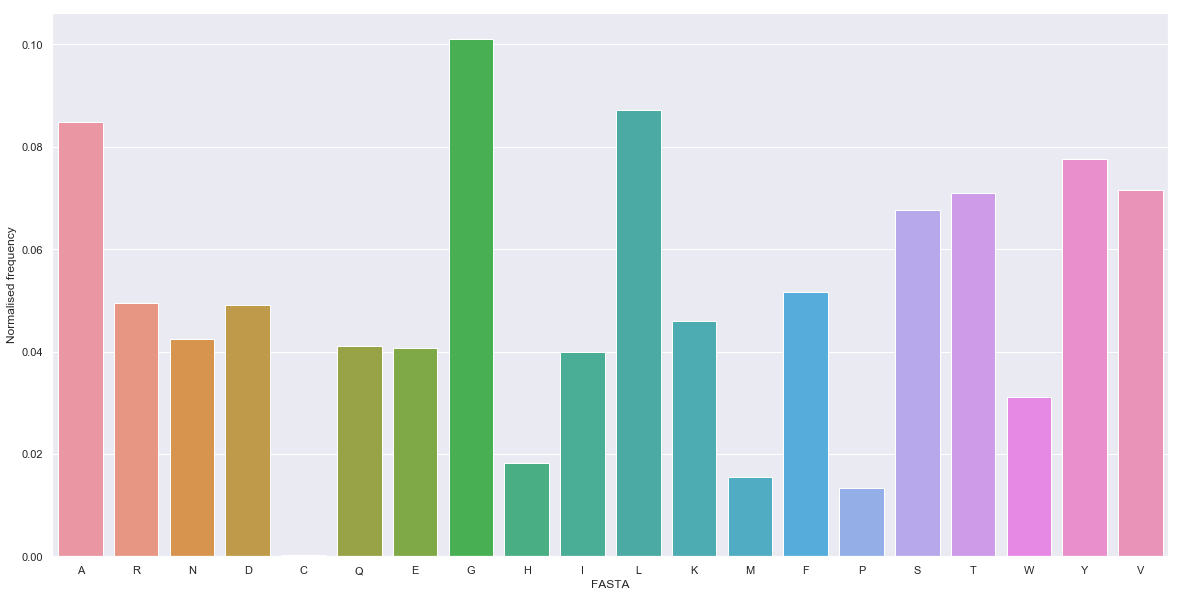

In [23]:
barrel_distribution = calc_distribution(barrel_df, aa_dict)

plt.clf()
plt.figure(figsize=(20, 10))
sns.barplot(x='FASTA', y='Normalised frequency', data=barrel_distribution)
plt.show()

In [24]:
for aa in list(aa_dict.keys()):
    print(aa + ': ' + str(barrel_df['fasta_seq'].tolist().count(aa)))

A: 492
R: 287
N: 246
D: 285
C: 2
Q: 239
E: 236
G: 587
H: 106
I: 232
L: 506
K: 267
M: 90
F: 300
P: 77
S: 393
T: 412
W: 181
Y: 450
V: 415


Too few Cys residues for meaningful analysis => discounted from further analysis

In [25]:
aa_dict_no_cys = copy.deepcopy(aa_dict)
aa_dict_no_cys.pop('C')

barrel_df = barrel_df[barrel_df['fasta_seq'] != 'C']
barrel_df = barrel_df.reset_index(drop=True)

In [26]:
aa_dict_no_cys

OrderedDict([('A', 'Ala'),
             ('R', 'Arg'),
             ('N', 'Asn'),
             ('D', 'Asp'),
             ('Q', 'Gln'),
             ('E', 'Glu'),
             ('G', 'Gly'),
             ('H', 'His'),
             ('I', 'Ile'),
             ('L', 'Leu'),
             ('K', 'Lys'),
             ('M', 'Met'),
             ('F', 'Phe'),
             ('P', 'Pro'),
             ('S', 'Ser'),
             ('T', 'Thr'),
             ('W', 'Trp'),
             ('Y', 'Tyr'),
             ('V', 'Val')])

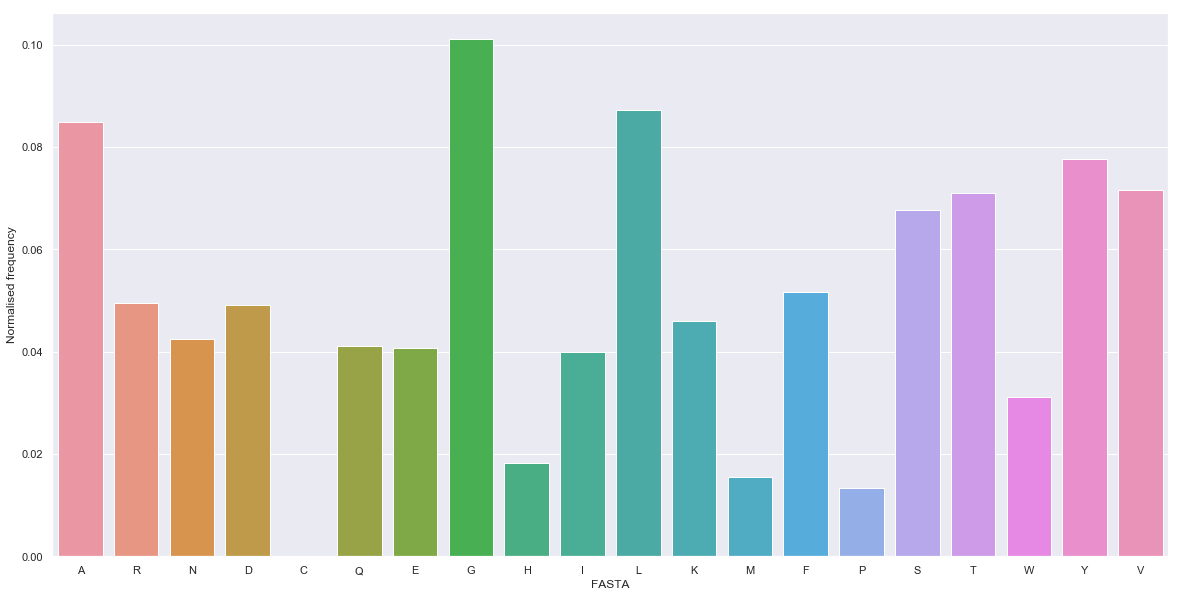

In [27]:
barrel_distribution = calc_distribution(barrel_df, aa_dict)

plt.clf()
plt.figure(figsize=(20, 10))
sns.barplot(x='FASTA', y='Normalised frequency', data=barrel_distribution)
plt.show()

In [28]:
for aa in list(aa_dict_no_cys.keys()):
    print(aa + ': ' + str(barrel_df['fasta_seq'].tolist().count(aa)))

A: 492
R: 287
N: 246
D: 285
Q: 239
E: 236
G: 587
H: 106
I: 232
L: 506
K: 267
M: 90
F: 300
P: 77
S: 393
T: 412
W: 181
Y: 450
V: 415


How does this distribution compare to those previously determined?

In [ ]:
levitt_dict = OrderedDict({'A': 0.900, 'R': 0.990, 'N': 0.760, 'D': 0.720, 'C': 0.740, 'Q': 0.800, 'E': 0.750,
                           'G': 0.920, 'H': 1.080, 'I': 1.450, 'L': 1.020, 'K': 0.770, 'M': 0.970, 'F': 1.320,
                           'P': 0.640, 'S': 0.950, 'T': 1.210, 'W': 1.140, 'Y': 1.250, 'V': 1.490})
levitt_df = pd.DataFrame({'FASTA': list(levitt_dict.keys()),
                          'Propensity': list(levitt_dict.values())})

plt.clf()
plt.figure(figsize=(20, 10))
sns.barplot(x='FASTA', y='Propensity', data=levitt_df)
plt.show()

In [ ]:
chou_fasman_dict = OrderedDict({'A': 0.830, 'R': 0.930, 'N': 0.890, 'D': 0.540, 'C': 1.190, 'Q': 1.100, 'E': 0.370,
                                'G': 0.750, 'H': 0.870, 'I': 1.600, 'L': 1.300, 'K': 0.740, 'M': 1.050, 'F': 1.380, 
                                'P': 0.550, 'S': 0.750, 'T': 1.190, 'W': 1.370, 'Y': 1.470, 'V': 1.700})
chou_fasman_df = pd.DataFrame({'FASTA': list(chou_fasman_dict.keys()),
                               'Propensity': list(chou_fasman_dict.values())})

plt.clf()
plt.figure(figsize=(20, 10))
sns.barplot(x='FASTA', y='Propensity', data=chou_fasman_df)
plt.show()

### Interior / exterior propensity

In [ ]:
int_ext_propensity, int_ext_frequency, int_ext_normed_frequencies = calc_indv_property_propensities(
    barrel_df, 'int_ext', aa_dict_no_cys
)

In [ ]:
int_ext_propensity

In [ ]:
int_ext_frequency

In [ ]:
int_ext_normed_frequencies

In [ ]:
plot_bar_graphs(int_ext_propensity, 'Propensity')

In [ ]:
plot_bar_graphs(int_ext_frequency, 'Frequency')

In [ ]:
plot_bar_graphs(int_ext_normed_frequencies, 'Normalised frequencies')

In [ ]:
plot_heat_map(int_ext_propensity)

In [ ]:
plot_heat_map(int_ext_frequency)

In [ ]:
plot_heat_map(int_ext_normed_frequencies)

In [ ]:
(
    int_ext_bootstrap_propensity_dict, int_ext_bootstrap_frequency_dict, int_ext_bootstrap_normed_frequencies_dict
) = bootstrap_discrete_propensities(
    barrel_df, 'int_ext', aa_dict_no_cys, 100, calc_indv_property_propensities
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    int_ext_propensity, int_ext_bootstrap_propensity_dict, 'Propensity'
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    int_ext_frequency, int_ext_bootstrap_frequency_dict, 'Frequency'
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    int_ext_normed_frequencies, int_ext_bootstrap_normed_frequencies_dict, 'Normalised frequency'
)

In [ ]:
(
    int_ext_iterated_propensity_dict, int_ext_iterated_frequency_dict, int_ext_iterated_normed_frequencies_dict
) = iterate_bootstrap_propensities(
    barrel_df, 'int_ext', aa_dict_no_cys, [10, 30, 100, 300], calc_indv_property_propensities, int_ext_propensity,
    int_ext_frequency, int_ext_normed_frequencies
)

In [ ]:
int_ext_iterated_propensity_dict

### Transmembrane / external propensity

In [ ]:
tm_ext_propensity, tm_ext_frequency, tm_ext_normed_frequencies = calc_indv_property_propensities(
    barrel_df, 'tm_ext', aa_dict_no_cys
)

In [ ]:
tm_ext_propensity

In [ ]:
tm_ext_frequency

In [ ]:
tm_ext_normed_frequencies

In [ ]:
plot_bar_graphs(tm_ext_propensity, 'Propensity')

In [ ]:
plot_bar_graphs(tm_ext_frequency, 'Frequency')

In [ ]:
plot_bar_graphs(tm_ext_normed_frequencies, 'Normalised frequencies')

In [ ]:
plot_heat_map(tm_ext_propensity)

In [ ]:
plot_heat_map(tm_ext_frequency)

In [ ]:
plot_heat_map(tm_ext_normed_frequencies)

In [ ]:
(
    tm_ext_bootstrap_propensity_dict, tm_ext_bootstrap_frequency_dict, tm_ext_bootstrap_normed_frequencies_dict
) = bootstrap_discrete_propensities(
    barrel_df, 'tm_ext', aa_dict_no_cys, 10000, calc_indv_property_propensities
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    tm_ext_propensity, tm_ext_bootstrap_propensity_dict, 'Propensity'
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    tm_ext_frequency, tm_ext_bootstrap_frequency_dict, 'Frequency'
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    tm_ext_normed_frequencies, tm_ext_bootstrap_normed_frequencies_dict, 'Normalised frequency'
)

### All combinations propensities

In [ ]:
(int_ext_tm_ext_propensity, int_ext_tm_ext_frequency, int_ext_tm_ext_normed_frequencies
 ) = calc_combined_property_propensities(barrel_df, ['int_ext', 'tm_ext'], aa_dict_no_cys)

In [ ]:
int_ext_tm_ext_propensity

In [ ]:
int_ext_tm_ext_frequency

In [ ]:
int_ext_tm_ext_normed_frequencies

In [ ]:
plot_bar_graphs(int_ext_tm_ext_propensity, 'Propensity')

In [ ]:
plot_bar_graphs(int_ext_tm_ext_frequency, 'Frequency')

In [ ]:
plot_bar_graphs(int_ext_tm_ext_normed_frequencies, 'Normalised frequencies')

In [ ]:
plot_heat_map(int_ext_tm_ext_propensity)

In [ ]:
plot_heat_map(int_ext_tm_ext_frequency)

In [ ]:
plot_heat_map(int_ext_tm_ext_normed_frequencies)

In [ ]:
(
    int_ext_tm_ext_bootstrap_propensity_dict, int_ext_tm_ext_bootstrap_frequency_dict,
    int_ext_tm_ext_bootstrap_normed_frequencies_dict
) = bootstrap_discrete_propensities(
    barrel_df, ['int_ext', 'tm_ext'], aa_dict_no_cys, 10000, calc_combined_property_propensities
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    int_ext_tm_ext_propensity, int_ext_tm_ext_bootstrap_propensity_dict, 'Propensity'
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    int_ext_tm_ext_frequency, int_ext_tm_ext_bootstrap_frequency_dict, 'Frequency'
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    int_ext_tm_ext_normed_frequencies, int_ext_tm_ext_bootstrap_normed_frequencies_dict, 'Normalised frequency'
)

### Z-coordinate amino acid KDEs

In [ ]:
plot_aa_kdes(barrel_df, ['z_coords'], 'individual', aa_dict_no_cys)

In [ ]:
int_barrel_df = barrel_df[barrel_df['int_ext'] == 'interior']
int_barrel_df = int_barrel_df.reset_index(drop=True)
plot_aa_kdes(int_barrel_df, ['z_coords'], 'individual', aa_dict_no_cys)

In [ ]:
ext_barrel_df = barrel_df[barrel_df['int_ext'] == 'exterior']
ext_barrel_df = ext_barrel_df.reset_index(drop=True)
plot_aa_kdes(ext_barrel_df, ['z_coords'], 'individual', aa_dict_no_cys)

In [ ]:
plot_aa_kdes(barrel_df, ['z_coords'], 'comparison', aa_dict_no_cys)

In [ ]:
plot_aa_kdes(int_barrel_df, ['z_coords'], 'comparison', aa_dict_no_cys)

In [ ]:
plot_aa_kdes(ext_barrel_df, ['z_coords'], 'comparison', aa_dict_no_cys)

In [ ]:
plot_1d_indv_aa_propensities(barrel_df, 'z_coords', aa_dict_no_cys)

In [ ]:
plot_1d_indv_aa_propensities(int_barrel_df, 'z_coords', aa_dict_no_cys)

In [ ]:
plot_1d_indv_aa_propensities(ext_barrel_df, 'z_coords', aa_dict_no_cys)

### 2D Kolmogorov-Smirnov test to compare individual and overall amino acid z-coordinate distributions

How many bootstrap samples should I use (all residues)?

In [ ]:
iterate_bootstrap_conf_limits(
    barrel_df, 'z_coords', run_ks_2samp_test, [100, 300, 1000, 3000, 10000, 30000, 100000], aa_dict_no_cys
)

Are the differences I observe between individual amino acid and overall amino acid distributions significant?

In [ ]:
initial_D_dict, initial_p_dict = initial_ks_test(barrel_df, 'z_coords', run_ks_2samp_test, aa_dict_no_cys)

D_dict_bootstrap, p_dict_bootstrap = bootstrap_ks_test(barrel_df, 'z_coords', 10000, run_ks_2samp_test, aa_dict_no_cys)
draw_plot(sns.violinplot, p_dict_bootstrap, list(aa_dict_no_cys.keys()), 'Amino acid', 'p')

barrel_conf_intv_p_dict = calc_95_conf_limits(initial_p_dict, p_dict_bootstrap)
draw_plot(sns.swarmplot, barrel_conf_intv_p_dict, list(aa_dict_no_cys.keys()), 'Amino acid', 'p')

How many bootstrap samples should I use (interior residues)?

In [ ]:
iterate_bootstrap_conf_limits(
    int_barrel_df, 'z_coords', run_ks_2samp_test, [100, 300, 1000, 3000, 10000, 30000, 100000], aa_dict_no_cys
)

Are the differences I observe between individual amino acid and overall amino acid distributions significant?

In [ ]:
initial_D_dict_int, initial_p_dict_int = initial_ks_test(int_barrel_df, 'z_coords', run_ks_2samp_test, aa_dict_no_cys)

D_dict_bootstrap_int, p_dict_bootstrap_int = bootstrap_ks_test(
    int_barrel_df, 'z_coords', 10000, run_ks_2samp_test, aa_dict_no_cys
)
draw_plot(sns.violinplot, p_dict_bootstrap_int, list(aa_dict_no_cys.keys()), 'Amino acid', 'p')

barrel_conf_intv_p_dict_int = calc_95_conf_limits(initial_p_dict_int, p_dict_bootstrap_int)
draw_plot(sns.swarmplot, barrel_conf_intv_p_dict_int, list(aa_dict_no_cys.keys()), 'Amino acid', 'p')

How many bootstrap samples should I use (exterior residues)?

In [ ]:
iterate_bootstrap_conf_limits(
    ext_barrel_df, 'z_coords', run_ks_2samp_test, [100, 300, 1000, 3000, 10000, 30000, 100000], aa_dict_no_cys
)

Are the differences I observe between individual amino acid and overall amino acid distributions significant?

In [ ]:
initial_D_dict_ext, initial_p_dict_ext = initial_ks_test(ext_barrel_df, 'z_coords', run_ks_2samp_test, aa_dict_no_cys)

D_dict_bootstrap_ext, p_dict_bootstrap_ext = bootstrap_ks_test(
    ext_barrel_df, 'z_coords', 10000, run_ks_2samp_test, aa_dict_no_cys
)
draw_plot(sns.violinplot, p_dict_bootstrap_ext, list(aa_dict_no_cys.keys()), 'Amino acid', 'p')

barrel_conf_intv_p_dict_ext = calc_95_conf_limits(initial_p_dict_ext, p_dict_bootstrap_ext)
draw_plot(sns.swarmplot, barrel_conf_intv_p_dict_ext, list(aa_dict_no_cys.keys()), 'Amino acid', 'p')

### Z-coordinate interaction type KDEs

In [ ]:
plot_discrete_prop_frequency_kdes(
    barrel_df, 'z_coords', ['van_der_waals', 'h_bonds', 'ionic', 'ss_bonds', 'pi_pi_stacking', 'pi_pi_stacking_p',
                            'pi_pi_stacking_l', 'pi_pi_stacking_n', 'pi_pi_stacking_t', 'cation_pi']
)

In [ ]:
plot_discrete_prop_frequency_kdes(
    int_barrel_df, 'z_coords', ['van_der_waals', 'h_bonds', 'ionic', 'ss_bonds', 'pi_pi_stacking', 'pi_pi_stacking_p',
                                'pi_pi_stacking_l', 'pi_pi_stacking_n', 'pi_pi_stacking_t', 'cation_pi']
)

In [ ]:
plot_discrete_prop_frequency_kdes(
    ext_barrel_df, 'z_coords', ['van_der_waals', 'h_bonds', 'ionic', 'ss_bonds', 'pi_pi_stacking', 'pi_pi_stacking_p',
                                'pi_pi_stacking_l', 'pi_pi_stacking_n', 'pi_pi_stacking_t', 'cation_pi']
)

### Residue mass KDEs

In [ ]:
# Average residue mass (Burlingame and Carr, 1996)
mass_list = [71.0788, 156.1876, 114.1039, 115.0886, 103.1448, 128.1308, 129.1155, 57.0520, 137.1412, 113.1595,
             113.1595, 128.1742, 131.1986, 147.1766, 97.1167, 87.0782, 101.1051, 186.2133, 163.1760, 99.1326]
mass_dict = define_dict(mass_list)

In [ ]:
plot_prop_vs_prop(barrel_df, 'z_coords', mass_dict, 'mass', 3, 8)

In [ ]:
plot_prop_vs_prop(int_barrel_df, 'z_coords', mass_dict, 'mass', 3, 8)

In [ ]:
plot_prop_vs_prop(ext_barrel_df, 'z_coords', mass_dict, 'mass', 3, 8)

### Hydrophobicity KDEs

In [ ]:
# Kyte and Doolittle scale
hydrophobicity_list = [1.8, -4.5, -3.5, -3.5, 2.5, -3.5, -3.5, -0.4, -3.2, 4.5, 3.8, -3.9, 1.9, 2.8, -1.6, -0.8,
                       -0.7, -0.9, -1.3, 4.2]
hydrophobicity_dict = define_dict(hydrophobicity_list)

In [ ]:
plot_prop_vs_prop(barrel_df, 'z_coords', hydrophobicity_dict, 'hydrophobicity', 3, 0.5)

In [ ]:
plot_prop_vs_prop(int_barrel_df, 'z_coords', hydrophobicity_dict, 'hydrophobicity', 3, 0.5)

In [ ]:
plot_prop_vs_prop(ext_barrel_df, 'z_coords', hydrophobicity_dict, 'hydrophobicity', 3, 0.5)

### Side chain volume KDEs

In [ ]:
# Side chain volume (Krigbaum-Komoriya, 1979)
side_chain_volume_list = [27.5, 105.0, 58.7, 40.0, 44.6, 80.7, 62.0, 0.0, 79.0, 93.5, 93.5, 100.0, 94.1, 115.5, 41.9,
                          29.3, 51.3, 145.5, 117.3, 71.5]
side_chain_volume_dict = define_dict(side_chain_volume_list)

In [ ]:
plot_prop_vs_prop(barrel_df, 'z_coords', side_chain_volume_dict, 'side_chain_volume', 3, 10)

In [ ]:
plot_prop_vs_prop(int_barrel_df, 'z_coords', side_chain_volume_dict, 'side_chain_volume', 3, 10)

In [ ]:
plot_prop_vs_prop(ext_barrel_df, 'z_coords', side_chain_volume_dict, 'side_chain_volume', 3, 10)

### Side chain solvent accessible surface area KDEs

In [ ]:
# Side chain solvent accessible surface area (Miller et al, 1987)
side_chain_sasa_list = [67, 196, 113, 106, 104, 144, 138, 0, 151, 140, 137, 167, 160, 175, 105, 80, 102, 217, 187,
                        117]
sasa_dict = define_dict(side_chain_sasa_list)

In [ ]:
plot_prop_vs_prop(barrel_df, 'z_coords', sasa_dict, 'solvent_accessible_surface_area', 3, 15)

In [ ]:
plot_prop_vs_prop(int_barrel_df, 'z_coords', sasa_dict, 'solvent_accessible_surface_area', 3, 15)

In [ ]:
plot_prop_vs_prop(ext_barrel_df, 'z_coords', sasa_dict, 'solvent_accessible_surface_area', 3, 15)

### Charge KDEs

In [ ]:
# From pKa values of Cantor and Schimmel (1980)
"""
pka_dict = {'A': '',
            'R': 12,
            'N': '',
            'D': 4.5,
            'C': 8.65,
            'Q': '',
            'E': 4.5,
            'G': '',
            'H': 6.75,
            'I': '',
            'L': '',
            'K': 10.1,
            'M': '',
            'F': '',
            'P': '',
            'S': '',
            'T': '',
            'W': '',
            'Y': 9.8,
            'V': ''}
"""

charge_at_ph_7_list = [0, 1, 0, -1, -0.02, 0, -1, 0, 0.36, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
charge_at_ph_7_dict = define_dict(charge_at_ph_7_list)

In [ ]:
plot_prop_vs_prop(barrel_df, 'z_coords', charge_at_ph_7_dict, 'net_charge', 3, 0.1)

In [ ]:
plot_prop_vs_prop(int_barrel_df, 'z_coords', charge_at_ph_7_dict, 'net_charge', 3, 0.1)

In [ ]:
plot_prop_vs_prop(ext_barrel_df, 'z_coords', charge_at_ph_7_dict, 'net_charge', 3, 0.1)

### Positive charge KDEs

In [ ]:
posi_charge_at_ph_7_list = [0, 1, 0, 0, 0, 0, 0, 0, 0.36, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
posi_charge_at_ph_7_dict = define_dict(posi_charge_at_ph_7_list)

In [ ]:
plot_prop_vs_prop(barrel_df, 'z_coords', posi_charge_at_ph_7_dict, 'positive_charge', 3, 0.1)

In [ ]:
plot_prop_vs_prop(int_barrel_df, 'z_coords', posi_charge_at_ph_7_dict, 'positive_charge', 3, 0.1)

In [ ]:
plot_prop_vs_prop(ext_barrel_df, 'z_coords', posi_charge_at_ph_7_dict, 'positive_charge', 3, 0.1)

### Negative KDEs

In [ ]:
neg_charge_at_ph_7_list = [0, 0, 0, -1, -0.02, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
neg_charge_at_ph_7_dict = define_dict(neg_charge_at_ph_7_list)

In [ ]:
plot_prop_vs_prop(barrel_df, 'z_coords', neg_charge_at_ph_7_dict, 'negative_charge', 3, 0.1)

In [ ]:
plot_prop_vs_prop(int_barrel_df, 'z_coords', neg_charge_at_ph_7_dict, 'negative_charge', 3, 0.1)

In [ ]:
plot_prop_vs_prop(ext_barrel_df, 'z_coords', neg_charge_at_ph_7_dict, 'negative_charge', 3, 0.1)

### Polarity KDEs

In [ ]:
# Mean polarity (Radzicka-Wolfenden, 1988)
polarity_list = [-0.06, -0.84, -0.48, -0.80, 1.36, -0.73, -0.77, -0.41, 0.49, 1.31, 1.21, -1.18, 1.27, 1.27, 0.0,
                 -0.50, -0.27, 0.88, 0.33,  1.09]
polarity_dict = define_dict(polarity_list)

In [ ]:
plot_prop_vs_prop(barrel_df, 'z_coords', polarity_dict, 'polarity', 3, 0.17)

In [ ]:
plot_prop_vs_prop(int_barrel_df, 'z_coords', polarity_dict, 'polarity', 3, 0.17)

In [ ]:
plot_prop_vs_prop(ext_barrel_df, 'z_coords', polarity_dict, 'polarity', 3, 0.17)

### Aromaticity KDEs

In [ ]:
# 1 = aromatic, 0 = not aromatic
aromaticity_list = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
aromaticity_dict = define_dict(aromaticity_list)

In [ ]:
plot_prop_vs_prop(barrel_df, 'z_coords', aromaticity_dict, 'aromaticity', 3, 0.1)

In [ ]:
plot_prop_vs_prop(int_barrel_df, 'z_coords', aromaticity_dict, 'aromaticity', 3, 0.1)

In [ ]:
plot_prop_vs_prop(ext_barrel_df, 'z_coords', aromaticity_dict, 'aromaticity', 3, 0.1)

### Flexibility KDEs

In [ ]:
# Average flexibility indices in globular proteins (Bhaskaran-Ponnuswamy, 1988)
flexibility_list = [52.6, 109.1, 75.7, 68.4, 68.3, 89.7, 84.7, 36.3, 91.9, 102.0, 102.0, 105.1, 97.7, 113.9, 73.6,
                    54.9, 71.2, 135.4, 116.2, 85.1]
flexibility_dict = define_dict(flexibility_list)

In [ ]:
plot_prop_vs_prop(barrel_df, 'z_coords', flexibility_dict, 'flexibility', 3, 10)

In [ ]:
plot_prop_vs_prop(int_barrel_df, 'z_coords', flexibility_dict, 'flexibility', 3, 10)

In [ ]:
plot_prop_vs_prop(ext_barrel_df, 'z_coords', flexibility_dict, 'flexibility', 3, 10)

### Dihedral angle KDEs

In [ ]:
plot_prop_vs_dihedral(barrel_df, 'z_coords', 'phi')

In [ ]:
plot_prop_vs_dihedral(barrel_df, 'z_coords', 'psi')

In [ ]:
plot_prop_vs_dihedral(barrel_df, 'z_coords', 'omega')

In [ ]:
plot_prop_vs_dihedral(int_barrel_df, 'z_coords', 'phi')

In [ ]:
plot_prop_vs_dihedral(int_barrel_df, 'z_coords', 'psi')

In [ ]:
plot_prop_vs_dihedral(int_barrel_df, 'z_coords', 'omega')

In [ ]:
plot_prop_vs_dihedral(ext_barrel_df, 'z_coords', 'phi')

In [ ]:
plot_prop_vs_dihedral(ext_barrel_df, 'z_coords', 'psi')

In [ ]:
plot_prop_vs_dihedral(ext_barrel_df, 'z_coords', 'omega')

### Van der Waals interactions amino acid pair propensities

In [ ]:
vdw_pairs = gen_neighbouring_pairs_list(barrel_df, 'van_der_waals', aa_dict_no_cys)
vdw_propensity, vdw_frequency, vdw_normed_frequencies = calc_aa_pair_propensities(vdw_pairs, aa_dict_no_cys)

In [ ]:
vdw_propensity

In [ ]:
vdw_frequency

In [ ]:
vdw_normed_frequencies

In [ ]:
plot_heat_map(vdw_propensity)

In [ ]:
plot_heat_map(vdw_frequency)

In [ ]:
plot_heat_map(vdw_normed_frequencies)

In [ ]:
(
    vdw_bootstrap_propensity_dict, vdw_bootstrap_frequency_dict, vdw_bootstrap_normed_frequencies_dict
) = bootstrap_discrete_propensities(
    barrel_df, 'van_der_waals', aa_dict_no_cys, 10000, calc_aa_pair_propensities
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    vdw_propensity, vdw_bootstrap_propensity_dict, 'Propensity'
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    vdw_frequency, vdw_bootstrap_frequency_dict, 'Frequency'
)

In [ ]:
plot_bar_graphs_with_conf_limits(
    vdw_normed_frequencies, vdw_bootstrap_normed_frequencies_dict, 'Normalised frequency'
)

In [ ]:
plot_pairwise_propensities(barrel_vdw_z_dict, aa_dict_no_cys, barrel_vdw_propensity)

In [ ]:
(int_barrel_vdw_propensity, int_barrel_vdw_frequency, int_barrel_vdw_normed_frequencies, int_barrel_vdw_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'van_der_waals_fasta_intra', aa_dict_no_cys)

In [ ]:
int_barrel_vdw_propensity

In [ ]:
int_barrel_vdw_frequency

In [ ]:
int_barrel_vdw_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_vdw_propensity)

In [ ]:
plot_heat_map(int_barrel_vdw_frequency)

In [ ]:
plot_heat_map(int_barrel_vdw_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_vdw_z_dict, aa_dict_no_cys, int_barrel_vdw_propensity)

In [ ]:
(ext_barrel_vdw_propensity, ext_barrel_vdw_frequency, ext_barrel_vdw_normed_frequencies, ext_barrel_vdw_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'van_der_waals_fasta_intra', aa_dict_no_cys)

In [ ]:
ext_barrel_vdw_propensity

In [ ]:
ext_barrel_vdw_frequency

In [ ]:
ext_barrel_vdw_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_vdw_propensity)

In [ ]:
plot_heat_map(ext_barrel_vdw_frequency)

In [ ]:
plot_heat_map(ext_barrel_vdw_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_vdw_z_dict, aa_dict_no_cys, ext_barrel_vdw_propensity)

### Hydrogen bonding interaction amino acid pair propensities

In [ ]:
(barrel_hbonds_propensity, barrel_hbonds_frequency, barrel_hbonds_normed_frequencies, barrel_hbonds_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'h_bonds_fasta_intra', aa_dict_no_cys)

In [ ]:
barrel_hbonds_propensity

In [ ]:
barrel_hbonds_frequency

In [ ]:
barrel_hbonds_normed_frequencies

In [ ]:
plot_heat_map(barrel_hbonds_propensity)

In [ ]:
plot_heat_map(barrel_hbonds_frequency)

In [ ]:
plot_heat_map(barrel_hbonds_normed_frequencies)

In [ ]:
plot_pairwise_propensities(barrel_hbonds_z_dict, aa_dict_no_cys, barrel_hbonds_propensity)

In [ ]:
(int_barrel_hbonds_propensity, int_barrel_hbonds_frequency, int_barrel_hbonds_normed_frequencies, int_barrel_hbonds_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'h_bonds_fasta_intra', aa_dict_no_cys)

In [ ]:
int_barrel_hbonds_propensity

In [ ]:
int_barrel_hbonds_frequency

In [ ]:
int_barrel_hbonds_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_hbonds_propensity)

In [ ]:
plot_heat_map(int_barrel_hbonds_frequency)

In [ ]:
plot_heat_map(int_barrel_hbonds_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_hbonds_z_dict, aa_dict_no_cys, int_barrel_hbonds_propensity)

In [ ]:
(ext_barrel_hbonds_propensity, ext_barrel_hbonds_frequency, ext_barrel_hbonds_normed_frequencies, ext_barrel_hbonds_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'h_bonds_fasta_intra', aa_dict_no_cys)

In [ ]:
ext_barrel_hbonds_propensity

In [ ]:
ext_barrel_hbonds_frequency

In [ ]:
ext_barrel_hbonds_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_hbonds_propensity)

In [ ]:
plot_heat_map(ext_barrel_hbonds_frequency)

In [ ]:
plot_heat_map(ext_barrel_hbonds_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_hbonds_z_dict, aa_dict_no_cys, ext_barrel_hbonds_propensity)

### Ionic interactions amino acid propensities

In [ ]:
(barrel_ionic_propensity, barrel_ionic_frequency, barrel_ionic_normed_frequencies, barrel_ionic_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'ionic_fasta_intra', aa_dict_no_cys)

In [ ]:
barrel_ionic_propensity

In [ ]:
barrel_ionic_frequency

In [ ]:
barrel_ionic_normed_frequencies

In [ ]:
plot_heat_map(barrel_ionic_propensity)

In [ ]:
plot_heat_map(barrel_ionic_frequency)

In [ ]:
plot_heat_map(barrel_ionic_normed_frequencies)

In [ ]:
plot_pairwise_propensities(barrel_ionic_z_dict, aa_dict_no_cys, barrel_ionic_propensity)

In [ ]:
(int_barrel_ionic_propensity, int_barrel_ionic_frequency, int_barrel_ionic_normed_frequencies, int_barrel_ionic_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'ionic_fasta_intra', aa_dict_no_cys)

In [ ]:
int_barrel_ionic_propensity

In [ ]:
int_barrel_ionic_frequency

In [ ]:
int_barrel_ionic_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_ionic_propensity)

In [ ]:
plot_heat_map(int_barrel_ionic_frequency)

In [ ]:
plot_heat_map(int_barrel_ionic_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_ionic_z_dict, aa_dict_no_cys, int_barrel_ionic_propensity)

In [ ]:
(ext_barrel_ionic_propensity, ext_barrel_ionic_frequency, ext_barrel_ionic_normed_frequencies, ext_barrel_ionic_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'ionic_fasta_intra', aa_dict_no_cys)

In [ ]:
ext_barrel_ionic_propensity

In [ ]:
ext_barrel_ionic_frequency

In [ ]:
ext_barrel_ionic_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_ionic_propensity)

In [ ]:
plot_heat_map(ext_barrel_ionic_frequency)

In [ ]:
plot_heat_map(ext_barrel_ionic_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_ionic_z_dict, aa_dict_no_cys, ext_barrel_ionic_propensity)

### Disulphide bonds amino acid propensities

In [ ]:
(barrel_ss_propensity, barrel_ss_frequency, barrel_ss_normed_frequencies, barrel_ss_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'ss_bonds_fasta_intra', aa_dict_no_cys)

In [ ]:
barrel_ss_propensity

In [ ]:
barrel_ss_frequency

In [ ]:
barrel_ss_normed_frequencies

### Pi-pi stacking interactions amino acid propensities

In [ ]:
(barrel_pipi_propensity, barrel_pipi_frequency, barrel_pipi_normed_frequencies, barrel_pipi_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'pi_pi_stacking_fasta_intra', aa_dict_no_cys)

In [ ]:
barrel_pipi_propensity

In [ ]:
barrel_pipi_frequency

In [ ]:
barrel_pipi_normed_frequencies

In [ ]:
plot_heat_map(barrel_pipi_propensity)

In [ ]:
plot_heat_map(barrel_pipi_frequency)

In [ ]:
plot_heat_map(barrel_pipi_normed_frequencies)

In [ ]:
plot_pairwise_propensities(barrel_pipi_z_dict, aa_dict_no_cys, barrel_pipi_propensity)

In [ ]:
(int_barrel_pipi_propensity, int_barrel_pipi_frequency, int_barrel_pipi_normed_frequencies, int_barrel_pipi_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'pi_pi_stacking_fasta_intra', aa_dict_no_cys)

In [ ]:
int_barrel_pipi_propensity

In [ ]:
int_barrel_pipi_frequency

In [ ]:
int_barrel_pipi_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_pipi_propensity)

In [ ]:
plot_heat_map(int_barrel_pipi_frequency)

In [ ]:
plot_heat_map(int_barrel_pipi_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_pipi_z_dict, aa_dict_no_cys, int_barrel_pipi_propensity)

In [ ]:
(ext_barrel_pipi_propensity, ext_barrel_pipi_frequency, ext_barrel_pipi_normed_frequencies, ext_barrel_pipi_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'pi_pi_stacking_fasta_intra', aa_dict_no_cys)

In [ ]:
ext_barrel_pipi_propensity

In [ ]:
ext_barrel_pipi_frequency

In [ ]:
ext_barrel_pipi_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_pipi_propensity)

In [ ]:
plot_heat_map(ext_barrel_pipi_frequency)

In [ ]:
plot_heat_map(ext_barrel_pipi_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_pipi_z_dict, aa_dict_no_cys, ext_barrel_pipi_propensity)

### Pi-pi stacking P interactions amino acid propensities

In [ ]:
(barrel_pipi_p_propensity, barrel_pipi_p_frequency, barrel_pipi_p_normed_frequencies, barrel_pipi_p_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'pi_pi_stacking_fasta_intra_p', aa_dict_no_cys)

In [ ]:
barrel_pipi_p_propensity

In [ ]:
barrel_pipi_p_frequency

In [ ]:
barrel_pipi_p_normed_frequencies

In [ ]:
plot_heat_map(barrel_pipi_p_propensity)

In [ ]:
plot_heat_map(barrel_pipi_p_frequency)

In [ ]:
plot_heat_map(barrel_pipi_p_normed_frequencies)

In [ ]:
plot_pairwise_propensities(barrel_pipi_p_z_dict, aa_dict_no_cys, barrel_pipi_p_propensity)

In [ ]:
(int_barrel_pipi_p_propensity, int_barrel_pipi_p_frequency, int_barrel_pipi_p_normed_frequencies, int_barrel_pipi_p_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'pi_pi_stacking_fasta_intra_p', aa_dict_no_cys)

In [ ]:
int_barrel_pipi_p_propensity

In [ ]:
int_barrel_pipi_p_frequency

In [ ]:
int_barrel_pipi_p_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_pipi_p_propensity)

In [ ]:
plot_heat_map(int_barrel_pipi_p_frequency)

In [ ]:
plot_heat_map(int_barrel_pipi_p_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_pipi_p_z_dict, aa_dict_no_cys, int_barrel_pipi_p_propensity)

In [ ]:
(ext_barrel_pipi_p_propensity, ext_barrel_pipi_p_frequency, ext_barrel_pipi_p_normed_frequencies, ext_barrel_pipi_p_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'pi_pi_stacking_fasta_intra_p', aa_dict_no_cys)

In [ ]:
ext_barrel_pipi_p_propensity

In [ ]:
ext_barrel_pipi_p_frequency

In [ ]:
ext_barrel_pipi_p_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_pipi_p_propensity)

In [ ]:
plot_heat_map(ext_barrel_pipi_p_frequency)

In [ ]:
plot_heat_map(ext_barrel_pipi_p_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_pipi_p_z_dict, aa_dict_no_cys, ext_barrel_pipi_p_propensity)

### Pi-pi stacking L interactions amino acid propensities

In [ ]:
(barrel_pipi_l_propensity, barrel_pipi_l_frequency, barrel_pipi_l_normed_frequencies, barrel_pipi_l_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'pi_pi_stacking_fasta_intra_l', aa_dict_no_cys)

In [ ]:
barrel_pipi_l_propensity

In [ ]:
barrel_pipi_l_frequency

In [ ]:
barrel_pipi_l_normed_frequencies

In [ ]:
plot_heat_map(barrel_pipi_l_propensity)

In [ ]:
plot_heat_map(barrel_pipi_l_frequency)

In [ ]:
plot_heat_map(barrel_pipi_l_normed_frequencies)

In [ ]:
plot_pairwise_propensities(barrel_pipi_l_z_dict, aa_dict_no_cys, barrel_pipi_l_propensity)

In [ ]:
(int_barrel_pipi_l_propensity, int_barrel_pipi_l_frequency, int_barrel_pipi_l_normed_frequencies, int_barrel_pipi_l_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'pi_pi_stacking_fasta_intra_l', aa_dict_no_cys)

In [ ]:
int_barrel_pipi_l_propensity

In [ ]:
int_barrel_pipi_l_frequency

In [ ]:
int_barrel_pipi_l_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_pipi_l_propensity)

In [ ]:
plot_heat_map(int_barrel_pipi_l_frequency)

In [ ]:
plot_heat_map(int_barrel_pipi_l_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_pipi_l_z_dict, aa_dict_no_cys, int_barrel_pipi_l_propensity)

In [ ]:
(ext_barrel_pipi_l_propensity, ext_barrel_pipi_l_frequency, ext_barrel_pipi_l_normed_frequencies, ext_barrel_pipi_l_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'pi_pi_stacking_fasta_intra_l', aa_dict_no_cys)

In [ ]:
ext_barrel_pipi_l_propensity

In [ ]:
ext_barrel_pipi_l_frequency

In [ ]:
ext_barrel_pipi_l_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_pipi_l_propensity)

In [ ]:
plot_heat_map(ext_barrel_pipi_l_frequency)

In [ ]:
plot_heat_map(ext_barrel_pipi_l_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_pipi_l_z_dict, aa_dict_no_cys, ext_barrel_pipi_l_propensity)

### Pi-pi stacking N interactions amino acid propensities

In [ ]:
(barrel_pipi_n_propensity, barrel_pipi_n_frequency, barrel_pipi_n_normed_frequencies, barrel_pipi_n_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'pi_pi_stacking_fasta_intra_n', aa_dict_no_cys)

In [ ]:
barrel_pipi_n_propensity

In [ ]:
barrel_pipi_n_frequency

In [ ]:
barrel_pipi_n_normed_frequencies

In [ ]:
plot_heat_map(barrel_pipi_n_propensity)

In [ ]:
plot_heat_map(barrel_pipi_n_frequency)

In [ ]:
plot_heat_map(barrel_pipi_n_normed_frequencies)

In [ ]:
plot_pairwise_propensities(barrel_pipi_n_z_dict, aa_dict_no_cys, barrel_pipi_n_propensity)

In [ ]:
(int_barrel_pipi_n_propensity, int_barrel_pipi_n_frequency, int_barrel_pipi_n_normed_frequencies, int_barrel_pipi_n_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'pi_pi_stacking_fasta_intra_n', aa_dict_no_cys)

In [ ]:
int_barrel_pipi_n_propensity

In [ ]:
int_barrel_pipi_n_frequency

In [ ]:
int_barrel_pipi_n_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_pipi_n_propensity)

In [ ]:
plot_heat_map(int_barrel_pipi_n_frequency)

In [ ]:
plot_heat_map(int_barrel_pipi_n_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_pipi_n_z_dict, aa_dict_no_cys, int_barrel_pipi_n_propensity)

In [ ]:
(ext_barrel_pipi_n_propensity, ext_barrel_pipi_n_frequency, ext_barrel_pipi_n_normed_frequencies, ext_barrel_pipi_n_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'pi_pi_stacking_fasta_intra_n', aa_dict_no_cys)

In [ ]:
ext_barrel_pipi_n_propensity

In [ ]:
ext_barrel_pipi_n_frequency

In [ ]:
ext_barrel_pipi_n_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_pipi_n_propensity)

In [ ]:
plot_heat_map(ext_barrel_pipi_n_frequency)

In [ ]:
plot_heat_map(ext_barrel_pipi_n_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_pipi_n_z_dict, aa_dict_no_cys, ext_barrel_pipi_n_propensity)

### Pi-pi stacking T interactions amino acid propensities

In [ ]:
(barrel_pipi_t_propensity, barrel_pipi_t_frequency, barrel_pipi_t_normed_frequencies, barrel_pipi_t_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'pi_pi_stacking_fasta_intra_t', aa_dict_no_cys)

In [ ]:
barrel_pipi_t_propensity

In [ ]:
barrel_pipi_t_frequency

In [ ]:
barrel_pipi_t_normed_frequencies

In [ ]:
plot_heat_map(barrel_pipi_t_propensity)

In [ ]:
plot_heat_map(barrel_pipi_t_frequency)

In [ ]:
plot_heat_map(barrel_pipi_t_normed_frequencies)

In [ ]:
plot_pairwise_propensities(barrel_pipi_t_z_dict, aa_dict_no_cys, barrel_pipi_t_propensity)

In [ ]:
(int_barrel_pipi_t_propensity, int_barrel_pipi_t_frequency, int_barrel_pipi_t_normed_frequencies, int_barrel_pipi_t_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'pi_pi_stacking_fasta_intra_t', aa_dict_no_cys)

In [ ]:
int_barrel_pipi_t_propensity

In [ ]:
int_barrel_pipi_t_frequency

In [ ]:
int_barrel_pipi_t_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_pipi_t_propensity)

In [ ]:
plot_heat_map(int_barrel_pipi_t_frequency)

In [ ]:
plot_heat_map(int_barrel_pipi_t_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_pipi_t_z_dict, aa_dict_no_cys, int_barrel_pipi_t_propensity)

In [ ]:
(ext_barrel_pipi_t_propensity, ext_barrel_pipi_t_frequency, ext_barrel_pipi_t_normed_frequencies, ext_barrel_pipi_t_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'pi_pi_stacking_fasta_intra_t', aa_dict_no_cys)

In [ ]:
ext_barrel_pipi_t_propensity

In [ ]:
ext_barrel_pipi_t_frequency

In [ ]:
ext_barrel_pipi_t_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_pipi_t_propensity)

In [ ]:
plot_heat_map(ext_barrel_pipi_t_frequency)

In [ ]:
plot_heat_map(ext_barrel_pipi_t_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_pipi_t_z_dict, aa_dict_no_cys, ext_barrel_pipi_t_propensity)

### Cation-pi interactions amino acid propensities

In [ ]:
(barrel_cationpi_propensity, barrel_cationpi_frequency, barrel_cationpi_normed_frequencies, barrel_cationpi_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'cation_pi_fasta_intra', aa_dict_no_cys)

In [ ]:
barrel_cationpi_propensity

In [ ]:
barrel_cationpi_frequency

In [ ]:
barrel_cationpi_normed_frequencies

In [ ]:
plot_heat_map(barrel_cationpi_propensity)

In [ ]:
plot_heat_map(barrel_cationpi_frequency)

In [ ]:
plot_heat_map(barrel_cationpi_normed_frequencies)

In [ ]:
plot_pairwise_propensities(barrel_cationpi_z_dict, aa_dict_no_cys, barrel_cationpi_propensity)

In [ ]:
(int_barrel_cationpi_propensity, int_barrel_cationpi_frequency, int_barrel_cationpi_normed_frequencies, int_barrel_cationpi_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'cation_pi_fasta_intra', aa_dict_no_cys)

In [ ]:
int_barrel_cationpi_propensity

In [ ]:
int_barrel_cationpi_frequency

In [ ]:
int_barrel_cationpi_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_cationpi_propensity)

In [ ]:
plot_heat_map(int_barrel_cationpi_frequency)

In [ ]:
plot_heat_map(int_barrel_cationpi_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_cationpi_z_dict, aa_dict_no_cys, int_barrel_cationpi_propensity)

In [ ]:
(ext_barrel_cationpi_propensity, ext_barrel_cationpi_frequency, ext_barrel_cationpi_normed_frequencies, ext_barrel_cationpi_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'cation_pi_fasta_intra', aa_dict_no_cys)

In [ ]:
ext_barrel_cationpi_propensity

In [ ]:
ext_barrel_cationpi_frequency

In [ ]:
ext_barrel_cationpi_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_cationpi_propensity)

In [ ]:
plot_heat_map(ext_barrel_cationpi_frequency)

In [ ]:
plot_heat_map(ext_barrel_cationpi_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_cationpi_z_dict, aa_dict_no_cys, ext_barrel_cationpi_propensity)

### NHB pairs

In [ ]:
(barrel_nhb_propensity, barrel_nhb_frequency, barrel_nhb_normed_frequencies, barrel_nhb_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'nhb_pairs_fasta_intra', aa_dict_no_cys)

In [ ]:
barrel_nhb_propensity

In [ ]:
barrel_nhb_frequency

In [ ]:
barrel_nhb_normed_frequencies

In [ ]:
plot_heat_map(barrel_nhb_propensity)

In [ ]:
 plot_heat_map(barrel_nhb_frequency)

In [ ]:
 plot_heat_map(barrel_nhb_normed_frequencies)

In [ ]:
plot_pairwise_propensities(barrel_nhb_z_dict, aa_dict_no_cys, barrel_nhb_propensity)

In [ ]:
(int_barrel_nhb_propensity, int_barrel_nhb_frequency, int_barrel_nhb_normed_frequencies, int_barrel_nhb_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'nhb_pairs_fasta_intra', aa_dict_no_cys)

In [ ]:
int_barrel_nhb_propensity

In [ ]:
int_barrel_nhb_frequency

In [ ]:
int_barrel_nhb_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_nhb_propensity)

In [ ]:
 plot_heat_map(int_barrel_nhb_frequency)

In [ ]:
 plot_heat_map(int_barrel_nhb_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_nhb_z_dict, aa_dict_no_cys, int_barrel_nhb_propensity)

In [ ]:
(ext_barrel_nhb_propensity, ext_barrel_nhb_frequency, ext_barrel_nhb_normed_frequencies, ext_barrel_nhb_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'nhb_pairs_fasta_intra', aa_dict_no_cys)

In [ ]:
ext_barrel_nhb_propensity

In [ ]:
ext_barrel_nhb_frequency

In [ ]:
ext_barrel_nhb_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_nhb_propensity)

In [ ]:
 plot_heat_map(ext_barrel_nhb_frequency)

In [ ]:
 plot_heat_map(ext_barrel_nhb_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_nhb_z_dict, aa_dict_no_cys, ext_barrel_nhb_propensity)

### HB pairs

In [ ]:
(barrel_hb_propensity, barrel_hb_frequency, barrel_hb_normed_frequencies, barrel_hb_z_dict
 ) = calc_aa_pair_propensities(barrel_df, 'hb_pairs_fasta_intra', aa_dict_no_cys)

In [ ]:
barrel_hb_propensity

In [ ]:
barrel_hb_frequency

In [ ]:
barrel_hb_normed_frequencies

In [ ]:
plot_heat_map(barrel_hb_propensity)

In [ ]:
plot_heat_map(barrel_hb_frequency)

In [ ]:
plot_heat_map(barrel_hb_normed_frequencies)

In [ ]:
plot_pairwise_propensities(barrel_hb_z_dict, aa_dict_no_cys, barrel_hb_propensity)

In [ ]:
(int_barrel_hb_propensity, int_barrel_hb_frequency, int_barrel_hb_normed_frequencies, int_barrel_hb_z_dict
 ) = calc_aa_pair_propensities(int_barrel_df, 'hb_pairs_fasta_intra', aa_dict_no_cys)

In [ ]:
int_barrel_hb_propensity

In [ ]:
int_barrel_hb_frequency

In [ ]:
int_barrel_hb_normed_frequencies

In [ ]:
plot_heat_map(int_barrel_hb_propensity)

In [ ]:
plot_heat_map(int_barrel_hb_frequency)

In [ ]:
plot_heat_map(int_barrel_hb_normed_frequencies)

In [ ]:
plot_pairwise_propensities(int_barrel_hb_z_dict, aa_dict_no_cys, int_barrel_hb_propensity)

In [ ]:
(ext_barrel_hb_propensity, ext_barrel_hb_frequency, ext_barrel_hb_normed_frequencies, ext_barrel_hb_z_dict
 ) = calc_aa_pair_propensities(ext_barrel_df, 'hb_pairs_fasta_intra', aa_dict_no_cys)

In [ ]:
ext_barrel_hb_propensity

In [ ]:
ext_barrel_hb_frequency

In [ ]:
ext_barrel_hb_normed_frequencies

In [ ]:
plot_heat_map(ext_barrel_hb_propensity)

In [ ]:
plot_heat_map(ext_barrel_hb_frequency)

In [ ]:
plot_heat_map(ext_barrel_hb_normed_frequencies)

In [ ]:
plot_pairwise_propensities(ext_barrel_hb_z_dict, aa_dict_no_cys, ext_barrel_hb_propensity)

### Standard error of proportion

Recalculate HB / NHB standard error of proportion z-scores from count data in Dek's 1998 paper

In [ ]:
dek_sandwich_hb_pairs_dict, dek_sandwich_hb_pairs_total = gen_dek_sandwich_dicts(aa_dict, 'hb')
dek_sandwich_nhb_pairs_dict, dek_sandwich_nhb_pairs_total = gen_dek_sandwich_dicts(aa_dict, 'nhb')

dek_sandwich_hb_nhb_z_scores, dek_sandwich_hb_nhb_ratios = calc_std_error_proportion(
    aa_dict, dek_sandwich_hb_pairs_dict, dek_sandwich_nhb_pairs_dict, dek_sandwich_hb_pairs_total,
    dek_sandwich_nhb_pairs_total
)

In [ ]:
dek_sandwich_hb_nhb_z_scores

In [ ]:
print_significant_z_scores(dek_sandwich_hb_nhb_z_scores)

Calculate HB / NHB standard error of proportion z-scores for new data

In [ ]:
barrel_df_hb_pairs_count_dict, barrel_df_hb_pairs_total = calc_pair_proportions(
    barrel_df, 'hb_pairs', aa_dict_no_cys
)
barrel_df_nhb_pairs_count_dict, barrel_df_nhb_pairs_total = calc_pair_proportions(
    barrel_df, 'nhb_pairs', aa_dict_no_cys
)

barrel_df_hb_nhb_z_scores, barrel_df_hb_nhb_ratios = calc_std_error_proportion(
    aa_dict_no_cys, barrel_df_hb_pairs_count_dict, barrel_df_nhb_pairs_count_dict, barrel_df_hb_pairs_total,
    barrel_df_nhb_pairs_total
)

In [ ]:
barrel_df_hb_nhb_z_scores

In [ ]:
print_significant_z_scores(barrel_df_hb_nhb_z_scores)

In [ ]:
barrel_df_dek_sandwich_z_diff_dict = calc_z_diff(barrel_df_hb_nhb_z_scores, dek_sandwich_hb_nhb_z_scores)

In [ ]:
barrel_df_dek_sandwich_z_diff_dict

In [ ]:
int_barrel_df_hb_pairs_count_dict, int_barrel_df_hb_pairs_total = calc_pair_proportions(
    int_barrel_df, 'hb_pairs', aa_dict_no_cys
)
int_barrel_df_nhb_pairs_count_dict, int_barrel_df_nhb_pairs_total = calc_pair_proportions(
    int_barrel_df, 'nhb_pairs', aa_dict_no_cys
)

int_barrel_df_hb_nhb_z_scores, int_barrel_df_hb_nhb_ratios = calc_std_error_proportion(
    aa_dict_no_cys, int_barrel_df_hb_pairs_count_dict, int_barrel_df_nhb_pairs_count_dict,
    int_barrel_df_hb_pairs_total, int_barrel_df_nhb_pairs_total
)

In [ ]:
int_barrel_df_hb_nhb_z_scores

In [ ]:
print_significant_z_scores(int_barrel_df_hb_nhb_z_scores)

In [ ]:
int_barrel_df_dek_sandwich_z_diff_dict = calc_z_diff(int_barrel_df_hb_nhb_z_scores, dek_sandwich_hb_nhb_z_scores)

In [ ]:
int_barrel_df_dek_sandwich_z_diff_dict

In [ ]:
ext_barrel_df_hb_pairs_count_dict, ext_barrel_df_hb_pairs_total = calc_pair_proportions(
    ext_barrel_df, 'hb_pairs', aa_dict_no_cys
)
ext_barrel_df_nhb_pairs_count_dict, ext_barrel_df_nhb_pairs_total = calc_pair_proportions(
    ext_barrel_df, 'nhb_pairs', aa_dict_no_cys
)

ext_barrel_df_hb_nhb_z_scores, ext_barrel_df_hb_nhb_ratios = calc_std_error_proportion(
    aa_dict_no_cys, ext_barrel_df_hb_pairs_count_dict, ext_barrel_df_nhb_pairs_count_dict,
    ext_barrel_df_hb_pairs_total, ext_barrel_df_nhb_pairs_total
)

In [ ]:
ext_barrel_df_hb_nhb_z_scores

In [ ]:
print_significant_z_scores(ext_barrel_df_hb_nhb_z_scores)

In [ ]:
ext_barrel_df_dek_sandwich_z_diff_dict = calc_z_diff(ext_barrel_df_hb_nhb_z_scores, dek_sandwich_hb_nhb_z_scores)

In [ ]:
ext_barrel_df_dek_sandwich_z_diff_dict

### Enough residues to split by int/tm, ext/tm, int/ext, ext/ext?

In [ ]:
int_tm_df = barrel_df[(barrel_df['int_ext'] == 'interior') & (barrel_df['tm_ext'] == 'transmembrane')]
int_tm_df = int_tm_df.reset_index(drop=True)

In [ ]:
ext_tm_df = barrel_df[(barrel_df['int_ext'] == 'exterior') & (barrel_df['tm_ext'] == 'transmembrane')]
ext_tm_df = ext_tm_df.reset_index(drop=True)

In [ ]:
int_ext_df = barrel_df[(barrel_df['int_ext'] == 'interior') & (barrel_df['tm_ext'] == 'external')]
int_ext_df = int_ext_df.reset_index(drop=True)

In [ ]:
ext_ext_df = barrel_df[(barrel_df['int_ext'] == 'exterior') & (barrel_df['tm_ext'] == 'external')]
ext_ext_df = ext_ext_df.reset_index(drop=True)

### Saves propensity dictionaries to pickle file

In [ ]:
propensities_dict = OrderedDict({'int_z_-_-_indv': int_z_indv_propensity_dict,
                                 'ext_z_-_-_indv': ext_z_indv_propensity_dict,
                                 'int_bsa_-_-_indv': int_bsa_indv_propensity_dict,
                                 'ext_bsa_-_-_indv': ext_bsa_indv_propensity_dict,
                                 'int_z_-_-_pair': int_z_pair_propensity_dict,
                                 'ext_z_-_-_pair': ext_z_pair_propensity_dict,
                                 'int_bsa_-_-_pair': int_bsa_pair_propensity_dict,
                                 'ext_bsa_-_-_pair': ext_bsa_pair_propensity_dict,
                                 'int_z_bsa_-_indv': int_z_bsa_indv_propensity_dict,
                                 'ext_z_bsa_-_indv': ext_z_bsa_indv_propensity_dict,
                                 'int_z_bsa_-_pair': int_z_bsa_pair_propensity_dict,
                                 'ext_z_bsa_-_pair': ext_z_bsa_pair_propensity_dict,
                                 'int_phi_psi_-_indv': int_phi_psi_indv_propensity_dict,
                                 'ext_phi_psi_-_indv': ext_phi_psi_indv_propensity_dict,
                                 'int_phi_psi_-_pair': int_phi_psi_pair_propensity_dict,
                                 'ext_phi_psi_-_pair': ext_phi_psi_pair_propensity_dict})

with open('Pickled_propensity_dictionaries.pkl', 'wb') as pickle_file:
    pickle.dump(propensities_dict, pickle_file)

In [ ]:
# Unused function
def calc_propensity(temp_lists, aa_df_prop_list, prop, index):
    try:
        temp_lists['{}_{}_count'.format(prop, aa)] = aa_df_prop_list.count(prop)
        temp_lists['{}_frequency_list'.format(prop)][index] = copy.deepcopy(temp_lists['{}_{}_count'.format(prop, aa)])

        temp_lists['{}_{}_normed_frequency'.format(prop, aa)] = temp_lists['{}_{}_count'.format(prop, aa)] / temp_lists['total_{}_count'.format(prop)]
        temp_lists['{}_normed_frequency_list'.format(prop)][index] = temp_lists['{}_{}_normed_frequency'.format(prop_val, aa)]

        temp_lists['{}_{}_propensity'.format(prop_val, aa)] = ((temp_lists['{}_{}_normed_frequency'.format(prop_val, aa)])
                                                               / (aa_df.shape[0] / df.shape[0]))
        temp_lists['{}_propensity_list'.format(prop_val)][index] = temp_lists['{}_{}_propensity'.format(prop_val, aa)]
    except ZeroDivisionError:
        temp_lists['{}_frequency_list'.format(prop_val)][index] = np.nan
        temp_lists['{}_normed_frequency_list'.format(prop_val)][index] = np.nan
        temp_lists['{}_propensity_list'.format(prop_val)][index] = np.nan
    return temp_lists